In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(2024)

from skimage.transform import resize
import pywt
import os
import scipy.io.wavfile as wavfile
from scipy.signal import butter, firwin, filtfilt, lfilter
import scipy.io
from scipy.signal import resample_poly
from scipy.spatial.distance import cdist
from IPython.display import display, Audio

#np.set_printoptions(threshold=np.inf)
#pd.option_context('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Best ECG channel

In [2]:
file_path='/labs/cliffordlab/fetal/leipzig/Version2/'
Annot_path_1='/labs/cliffordlab/fetal/leipzig/Annotations/ManualAnnotations/Beat_annotationAnno1'
Annot_path_2='/labs/cliffordlab/fetal/leipzig/Annotations/ManualAnnotations/Beat_annotationAnno2'

file_names=['AK101197V2','CB300482IIIV2','MZ290383V2','RM040883IIV2','SB280780_1V2']

In [3]:
sqi_counts_1 = np.zeros((5,7,5))
sqi_counts_2 = np.zeros((5,7,5))
j=0
for file in file_names:
    for i in range(1,8):
        ECG_path_1 = Annot_path_1 + '/' + file + f'_{i}_SQI.txt'
        ECG_path_2 = Annot_path_2 + '/' + file + f'_{i}_SQI.txt'
        
        
        ECG_SQI_1 = np.loadtxt(ECG_path_1, delimiter=',')
        for sqi_value in ECG_SQI_1:
            if 0 <= sqi_value <= 4: 
                sqi_counts_1[j,i-1,int(sqi_value)] += 1
        
        ECG_SQI_2 = np.loadtxt(ECG_path_2, delimiter=',')
        for sqi_value in ECG_SQI_2:
            if 0 <= sqi_value <= 4: 
                sqi_counts_2[j,i-1,int(sqi_value)] += 1
    j += 1



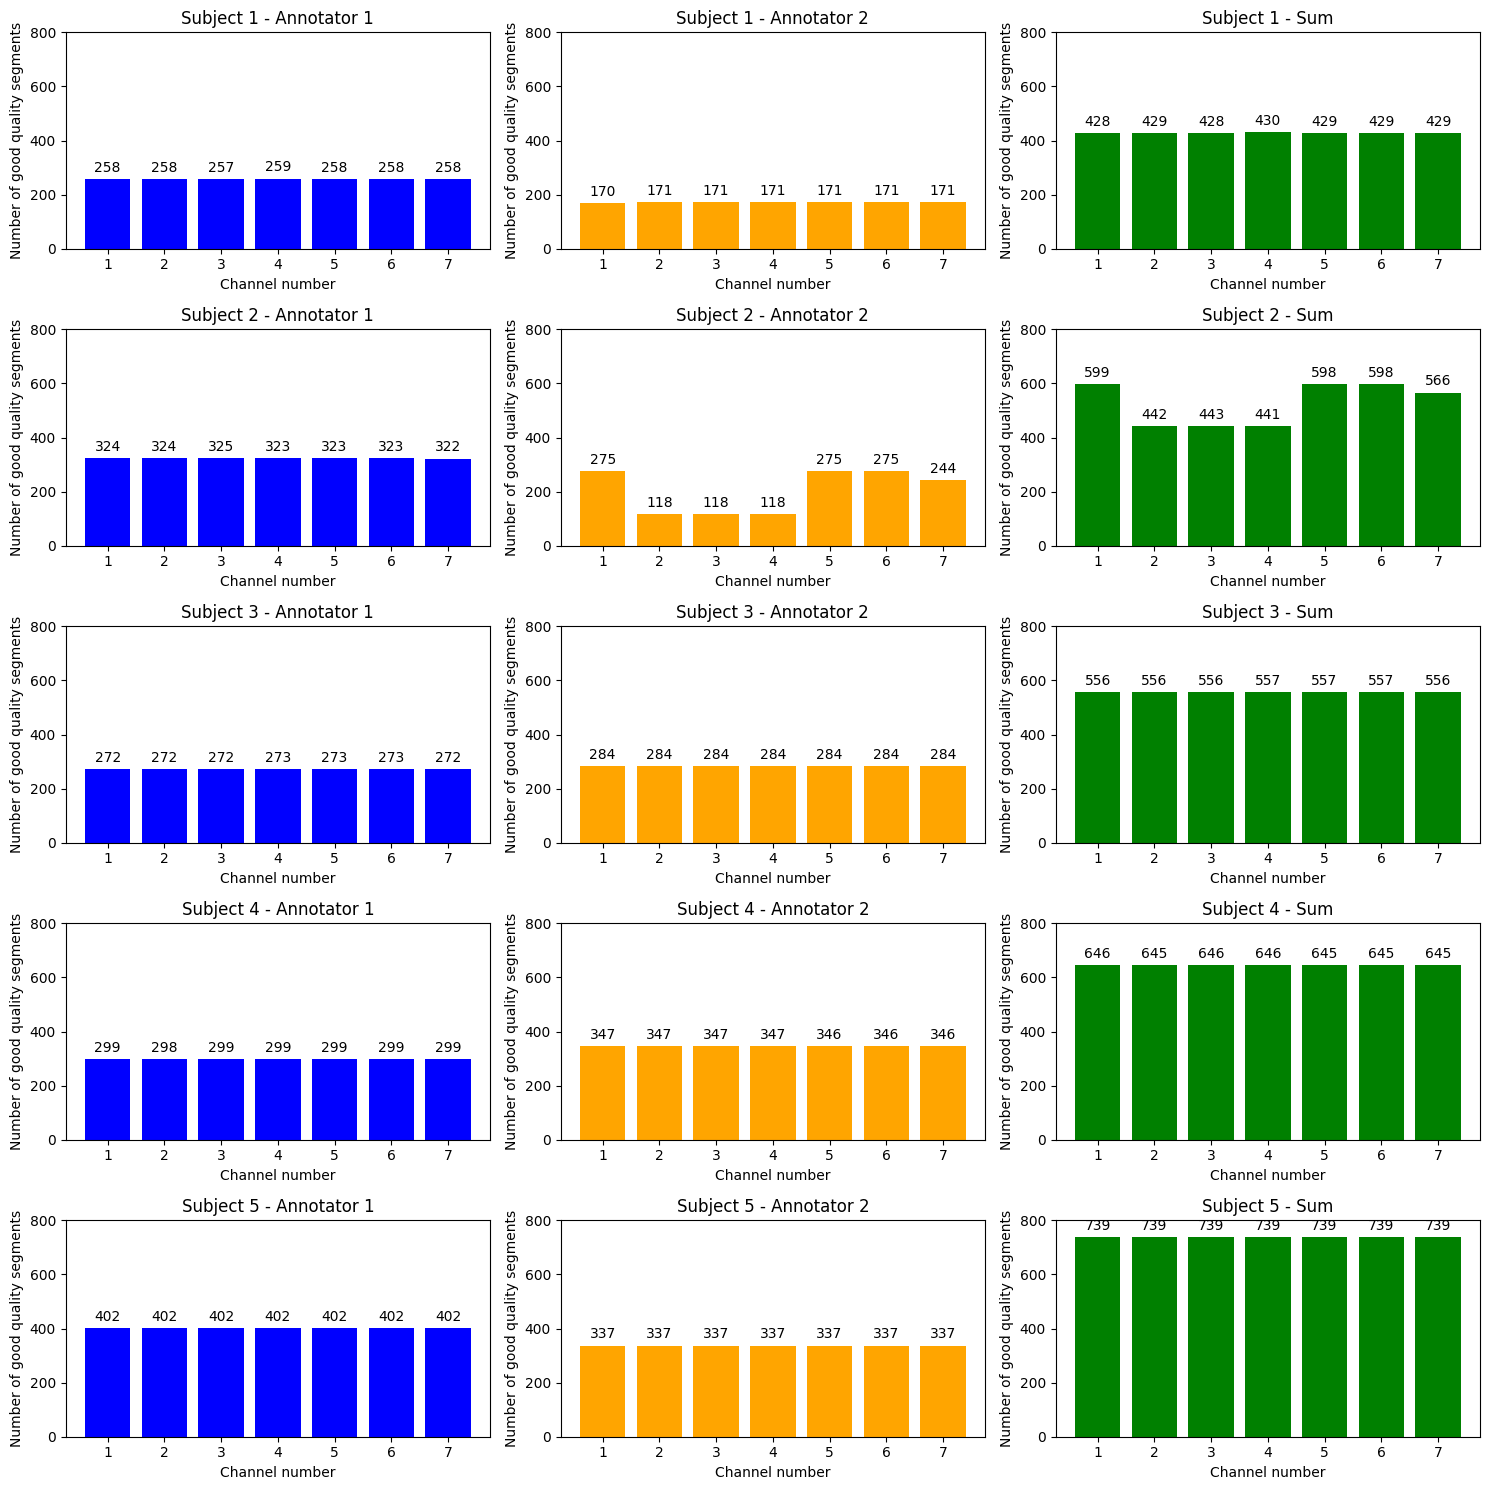

In [4]:
first_column_array1 = sqi_counts_1[:,:,0]  # All subjects, all rows, first column
first_column_array2 = sqi_counts_2[:,:,0]

sum_first_column = first_column_array1 + first_column_array2

# Setting up the figure and axes for the new bar charts, including the sum
fig, axs = plt.subplots(5, 3, figsize=(15, 15))  # 5 subjects, 3 arrays (side by side)

for i in range(5):  # Loop through each subject
    bars1 = axs[i, 0].bar(range(1, 8), first_column_array1[i], color='blue', label='Array 1')
    bars2 = axs[i, 1].bar(range(1, 8), first_column_array2[i], color='orange', label='Array 2')
    bars3 = axs[i, 2].bar(range(1, 8), sum_first_column[i], color='green', label='Sum of Arrays 1 & 2')

    # Annotating the value (y-axis) numbers on top of each bar
    for bar in bars1:
        height = bar.get_height()
        axs[i, 0].annotate(f'{height:.0f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        axs[i, 1].annotate(f'{height:.0f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

    for bar in bars3:
        height = bar.get_height()
        axs[i, 2].annotate(f'{height:.0f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

    axs[i, 0].set_ylim(0, 800)  
    axs[i, 1].set_ylim(0, 800)
    axs[i, 2].set_ylim(0, 800)
    
    axs[i, 0].set_title(f'Subject {i+1} - Annotator 1')
    axs[i, 1].set_title(f'Subject {i+1} - Annotator 2')
    axs[i, 2].set_title(f'Subject {i+1} - Sum')
    
    
    axs[i, 0].set_ylabel('Number of good quality segments')
    axs[i, 1].set_ylabel('Number of good quality segments')
    axs[i, 2].set_ylabel('Number of good quality segments')
    
    axs[i, 0].set_xlabel('Channel number')
    axs[i, 1].set_xlabel('Channel number')
    axs[i, 2].set_xlabel('Channel number')
    

plt.tight_layout()
plt.show()

In [37]:
sqi_counts_1

array([[[258.,   0.,   0.,   1., 129.],
        [258.,   0.,   0.,  30., 100.],
        [257.,   0.,   0.,  32.,  99.],
        [259.,   0.,   0., 112.,  17.],
        [258.,   0.,   0.,   0., 130.],
        [258.,   0.,   0.,   0., 130.],
        [258.,   0.,   0.,   0., 130.]],

       [[324.,  13.,  89.,  68.,   1.],
        [324., 143.,  23.,   5.,   0.],
        [325.,  53.,  51.,  65.,   1.],
        [323.,   2.,   5., 139.,  26.],
        [323.,   0.,   0.,   6., 166.],
        [323.,   0.,   0.,  61., 111.],
        [322.,   0.,   0.,   0., 173.]],

       [[272.,   2.,  56.,  71.,  16.],
        [272.,  19.,  97.,  27.,   2.],
        [272.,   5.,  63.,  61.,  16.],
        [273.,   0.,  69.,  58.,  17.],
        [273.,  31.,  67.,  30.,  16.],
        [273.,  59.,  49.,  21.,  15.],
        [272.,  95.,  39.,  11.,   0.]],

       [[299.,   0.,   6., 142.,  45.],
        [298.,   0.,  27., 153.,  14.],
        [299.,   1., 149.,  41.,   2.],
        [299.,   1., 154.,  38.,  

In [4]:
sqi_counts_1.sum(axis = 0)

array([[1555.,  174.,  172.,  282.,  191.],
       [1554.,  219.,  268.,  217.,  116.],
       [1555.,  120.,  381.,  200.,  118.],
       [1556.,  100.,  311.,  347.,   60.],
       [1555.,  206.,   73.,  137.,  403.],
       [1555.,  234.,   56.,  164.,  365.],
       [1553.,  271.,   45.,   97.,  408.]])

In [5]:
sqi_counts_2.sum(axis = 0)

array([[1413.,  240.,  142.,  407.,  111.],
       [1257.,  130.,  179.,  414.,  300.],
       [1257.,   74.,  183.,  453.,  313.],
       [1257.,   78.,  205.,  671.,   69.],
       [1413.,  211.,   59.,  245.,  386.],
       [1413.,  236.,   71.,  301.,  293.],
       [1382.,  296.,   63.,  298.,  243.]])

In [41]:
sqi_df_1 = pd.DataFrame(sqi_counts_1).astype('int')
sqi_df_1.loc[len(sqi_df_1)] = sqi_df_1.sum()
sqi_df_1

0     1     2     3     4     5     6
0  1555  1554  1555  1556  1555  1555  1553
1   174   219   120   100   206   234   271
2   172   268   381   311    73    56    45
3   282   217   200   347   137   164    97
4   191   116   118    60   403   365   408
5  2374  2374  2374  2374  2374  2374  2374

In [42]:
sqi_df_2 = pd.DataFrame(sqi_counts_2).astype('int')
sqi_df_2.loc[len(sqi_df_2)] = sqi_df_2.sum()
sqi_df_2

0     1     2     3     4     5     6
0  1413  1257  1257  1257  1413  1413  1382
1   240   130    74    78   211   236   296
2   142   179   183   205    59    71    63
3   407   414   453   671   245   301   298
4   111   300   313    69   386   293   243
5  2313  2280  2280  2280  2314  2314  2282

# extracting the data

In [4]:
file_path='/labs/cliffordlab/fetal/leipzig/Version2/'
Annot_path_1='/labs/cliffordlab/fetal/leipzig/Annotations/ManualAnnotations/Beat_annotationAnno1'
Annot_path_2='/labs/cliffordlab/fetal/leipzig/Annotations/ManualAnnotations/Beat_annotationAnno2'

file_names=['CB300482IIIV2','MZ290383V2','RM040883IIV2','SB280780_1V2', 'AK101197V2']

signals = [np.squeeze(scipy.io.loadmat(file_path+file)['doppler']) for file in file_names]
ECGs=[np.squeeze(scipy.io.loadmat(file_path+file)['fECG']) for file in file_names]

In [6]:
ECGs

[array([[1.74938230e-06, 3.99194218e-02, 6.97789030e-02, ...,
         1.89178126e-02, 2.02161685e-02, 2.10460848e-02],
        [3.95645703e-06, 2.22040518e-02, 3.87348622e-02, ...,
         1.66325491e-02, 1.65352054e-02, 1.47329866e-02],
        [1.70024762e-07, 7.32423686e-03, 1.29437234e-02, ...,
         1.94629214e-02, 1.83686465e-02, 1.52694749e-02],
        ...,
        [1.40615532e-05, 2.60699633e-01, 4.60805357e-01, ...,
         1.96259548e-04, 2.59979262e-03, 4.98602897e-03],
        [1.88460463e-05, 4.41750024e-01, 7.73696494e-01, ...,
         8.42864856e-03, 9.89425813e-03, 1.06223130e-02],
        [1.62844406e-05, 3.45199675e-01, 6.06838399e-01, ...,
         6.92568833e-03, 7.20101101e-03, 6.91339546e-03]]),
 array([[ 4.97383563e-06,  1.90871542e-02,  3.15158123e-02, ...,
         -4.56222888e-03, -3.12588848e-03, -1.67225669e-03],
        [-7.06762452e-08,  1.50756328e-02,  2.75722305e-02, ...,
          2.40655628e-04,  2.06933628e-03,  3.78713625e-03],
        [ 1.1

In [5]:
first_fECG = './AK101197_fECG.mat'
ffECG = scipy.io.loadmat(first_fECG)['all']
ffECG

array([[-3.24572553e-02, -6.03755120e-01, -7.47856845e-01, ...,
        -2.98671907e-02, -3.29109698e-02, -9.01853990e-03],
       [-2.08399169e-04, -2.54228052e-02, -3.83491438e-02, ...,
        -4.02593229e-03, -4.12874712e-03, -4.11673653e-03],
       [-3.49965039e-03, -3.60468334e-02, -2.31622236e-02, ...,
         4.15135676e-03,  4.05697207e-03,  4.33397557e-03],
       ...,
       [-1.58742054e-01, -5.99609713e-01, -6.35801523e-01, ...,
        -2.06135780e-02, -2.22290933e-02,  2.47848112e-03],
       [-1.34062890e-01, -5.65805460e-01, -6.25560534e-01, ...,
        -3.56230314e-02, -2.70255922e-02, -1.09435270e-02],
       [-1.50811178e-01, -6.11379774e-01, -6.30863041e-01, ...,
        -1.93995485e-02, -1.01673063e-02,  2.72884415e-03]])

In [6]:
ECGs_2 = ECGs[:-1]
ECGs_2.append(ffECG)

In [9]:
ECGs_2

[array([[1.74938230e-06, 3.99194218e-02, 6.97789030e-02, ...,
         1.89178126e-02, 2.02161685e-02, 2.10460848e-02],
        [3.95645703e-06, 2.22040518e-02, 3.87348622e-02, ...,
         1.66325491e-02, 1.65352054e-02, 1.47329866e-02],
        [1.70024762e-07, 7.32423686e-03, 1.29437234e-02, ...,
         1.94629214e-02, 1.83686465e-02, 1.52694749e-02],
        ...,
        [1.40615532e-05, 2.60699633e-01, 4.60805357e-01, ...,
         1.96259548e-04, 2.59979262e-03, 4.98602897e-03],
        [1.88460463e-05, 4.41750024e-01, 7.73696494e-01, ...,
         8.42864856e-03, 9.89425813e-03, 1.06223130e-02],
        [1.62844406e-05, 3.45199675e-01, 6.06838399e-01, ...,
         6.92568833e-03, 7.20101101e-03, 6.91339546e-03]]),
 array([[ 4.97383563e-06,  1.90871542e-02,  3.15158123e-02, ...,
         -4.56222888e-03, -3.12588848e-03, -1.67225669e-03],
        [-7.06762452e-08,  1.50756328e-02,  2.75722305e-02, ...,
          2.40655628e-04,  2.06933628e-03,  3.78713625e-03],
        [ 1.1

In [7]:
SQI_1 = []
SQI_2 = []
ECG_1=[]
ECG_2=[]
ECG_SQIC_1=[]
ECG_SQIC_2=[]
ECG_SQI_1=[]
ECG_SQI_2=[]

for file in file_names:
    SQI_path_1 = Annot_path_1 + '/' + file + '_Doppler_SQI.txt'
    SQI_path_2 = Annot_path_2 + '/' + file + '_Doppler_SQI.txt'
    
    SQI_data_1 = np.loadtxt(SQI_path_1, delimiter=',')
    SQI_1.append(SQI_data_1)
    
    SQI_data_2 = np.loadtxt(SQI_path_2, delimiter=',')
    SQI_2.append(SQI_data_2)
    
    ECG_SQIC_1=[]
    ECG_SQIC_2=[]
    for i in range(1,8):
        ECG_path_1 = Annot_path_1 + '/' + file + f'_{i}_SQI.txt'
        ECG_path_2 = Annot_path_2 + '/' + file + f'_{i}_SQI.txt'
        
        ECG_SQI1 = np.loadtxt(ECG_path_1, delimiter=',')
        ECG_SQIC_1.append(ECG_SQI1)
        ECG_SQI2 = np.loadtxt(ECG_path_2, delimiter=',')
        ECG_SQIC_2.append(ECG_SQI2)
        
    ECG_SQI_1.append(ECG_SQIC_1)
    ECG_SQI_2.append(ECG_SQIC_2)

    
    ECG_path_1 = Annot_path_1 + '/' + file + '_2.txt'
    ECG_path_2 = Annot_path_2 + '/' + file + '_2.txt'
    
    
    ECG_data_1 = np.loadtxt(ECG_path_1, delimiter=',')
    ECG_1.append(ECG_data_1[:,0])
    
    ECG_data_2 = np.loadtxt(ECG_path_2, delimiter=',')
    ECG_2.append(ECG_data_2[:,0])

In [37]:
ECG_SQI_2[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       2., 1., 2., 3., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 1., 3.,
       2., 2., 3., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 2., 1., 1.,
       2., 2., 3., 1., 1., 2., 1., 2., 2., 2., 2., 1., 1., 1., 1., 1., 4.,
       1., 1., 2., 4., 1., 2., 1., 2., 2., 3., 2., 2., 2., 3., 2., 2., 1.,
       3., 3., 1., 1., 2., 4., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 0.,
       2., 0., 0., 0., 2., 0., 2., 2., 2., 2., 2., 3., 2., 2., 2., 3., 3.,
       2., 3., 2., 2., 3.

In [33]:
SQI_1[0]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 6.,
       6., 2., 2., 2., 6., 1., 1., 1., 6., 1., 6., 6., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 1., 6., 6., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 6., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 6., 2., 2., 2., 1., 1., 1., 1., 1., 6., 6.,
       1., 1., 2., 2., 1., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [11]:
len(ECG_SQI_1[2][1])

492

In [10]:
len(SQI_1[2])

492

In [16]:
len(SQI_1[0])+len(SQI_1[1])+len(SQI_1[2])+len(SQI_1[3])+len(SQI_1[4])

2468

In [8]:
def find_closest_index(lst, number):
    differences = [abs(x - number) for x in lst]
    closest_index = differences.index(min(differences))

    return closest_index

def modify_array(arr, limit):
    length = arr.shape[0]
    if length > limit:
        return arr[:limit]
    elif length < limit:
        padding_length = limit - length
        return np.pad(arr, (0, padding_length), 'constant', constant_values=(np.mean(arr),))
    else:
        return arr

def normalize_one(array):
    ecg_min = np.min(array)
    ecg_max = np.max(array)
    
    normalized_ecg = 2 * (array - ecg_min) / (ecg_max - ecg_min) - 1
    
    return normalized_ecg
    
def normalize(array):
    return (array - array.min())/(array.max() - array.min()) 

def normalize_mean_std(array):
    mean = np.mean(array)
    std = np.std(array)
    normalized_array = (array - mean) / std
    return normalized_array


def create_scalogram(sig,fs,time_bins, freq_bins):
    scales = np.arange(1, freq_bins+1)
    coeffs, _ = pywt.cwt(sig, scales, wavelet = 'morl', sampling_period=1/fs)
    f = abs(coeffs)
    f = resize(f, (np.shape(coeffs)[0], time_bins), mode = 'constant')
    return f

def create_scalogram_frequencies(sig,fs, time_bins, freq_bins):
    wavelet = 'morl'
    frequencies = np.linspace(0.1, 4, freq_bins)
    scales = pywt.central_frequency(wavelet) * fs / frequencies
    coeffs, _ = pywt.cwt(sig, scales, wavelet = 'morl', sampling_period=1/fs)
    f = abs(coeffs)
    f = resize(f, (np.shape(coeffs)[0], time_bins), mode = 'constant')
    return f


def convert_to_float(byte_string):
    string = byte_string.decode('utf-8')  # Decode byte string to a regular string
    number_str = string.split(',')[0]  # Split at the comma and take the first part
    return float(number_str)  # Convert to float

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def DUS_filtering(DUS):  
    #25-600Hz 4th order Butterworth band pass
    fs = 4000
    lowcut = 25.0
    highcut = 600.0
    DUS_f = butter_bandpass_filter(DUS, lowcut, highcut, fs, order=2)
    return DUS_f

def signal_resample(signal, original_fs, target_fs):
    gcd = np.gcd(original_fs, target_fs)
    up = target_fs // gcd
    down = original_fs // gcd
    resampled_signal=resample_poly(signal, up, down)
    return resampled_signal


def ECG_filtering(ecg_signal, sample_rate):
    pass_band = [3, 45]  # Pass band frequencies (Hz)
    
    # Nyquist frequency
    nyquist_rate = sample_rate / 2.0
    
    # Calculate the filter coefficients
    numtaps = 101  # Number of taps in the FIR filter
    fir_coefficients = firwin(numtaps, [pass_band[0] / nyquist_rate, pass_band[1] / nyquist_rate], pass_zero=False)
    
    # Apply the filter
    filtered_signal = filtfilt(fir_coefficients, 1, ecg_signal)
    
    return filtered_signal


In [9]:
import numpy as np
from scipy.spatial.distance import cdist

def findClosersDuplicates(beats, threshold):
    """
    Remove duplicates from beats array based on a threshold.
    """
    unique_beats = []
    prev_beat = -np.inf
    for beat in sorted(beats):
        if beat - prev_beat > threshold:
            unique_beats.append(beat)
            prev_beat = beat
    return np.array(unique_beats)

def groupingBeats_leipzig(beats1, beats2, fs):
    beats1 = findClosersDuplicates(beats1, 0.24 * fs)
    beats2 = findClosersDuplicates(beats2, 0.24 * fs)

    D = cdist(beats1[:, np.newaxis], beats2[:, np.newaxis]) #distance between a beat from beats1 and a beat from beats2

    idxMinBeats1 = np.argmin(D, axis=1)
    idxMinBeats2 = np.argmin(D, axis=0)

    beatSet = []
    
    if len(np.unique(idxMinBeats1)) == len(beats1):
        for i in range(len(beats1)):
            beatSet.append(np.mean([beats1[i], beats2[idxMinBeats1[i]]]))
        
        if len(beats1) != len(beats2):
            missingBeats2 = np.setdiff1d(range(len(beats2)), idxMinBeats1)
            for i in missingBeats2:
                beatSet.append(beats2[i])
    else:
        uniqueBeats2 = np.unique(idxMinBeats1)
        
        for i in uniqueBeats2:
            idxBeat1 = np.where(idxMinBeats1 == i)[0]
            
            if len(idxBeat1) == 1:
                beatSet.append(np.mean([beats1[idxBeat1[0]], beats2[i]]))
            else:
                closerBeat1FromBeat2 = idxMinBeats2[i]
                beatSet.append(np.mean([beats1[closerBeat1FromBeat2], beats2[i]]))
                extras = beats1[np.setdiff1d(idxBeat1, closerBeat1FromBeat2)]
                beatSet.extend(extras)

    return sorted(beatSet)

In [11]:
fs_ECG=1000
target_fs_Doppler=4000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_all_1 = []
ECG_list_all_1 = []
DUS_list_all_2 = []
ECG_list_all_2 = []
DUS_list_all_3 = []
ECG_list_all_3 = []
DUS_list_all_4 = []
ECG_list_all_4 = []
DUS_list_all_5 = []
ECG_list_all_5 = []

DUS_list_all_train_1 = []
ECG_list_all_train_1 = []
DUS_list_all_train_2 = []
ECG_list_all_train_2 = []
DUS_list_all_train_3 = []
ECG_list_all_train_3 = []
DUS_list_all_train_4 = []
ECG_list_all_train_4 = []
DUS_list_all_train_5 = []
ECG_list_all_train_5 = []

FHR_list_all_1 = []
FHR_list_all_2 = []
FHR_list_all_3 = []
FHR_list_all_4 = []
FHR_list_all_5 = []
FHR_list_all_train_1 = []
FHR_list_all_train_2 = []
FHR_list_all_train_3 = []
FHR_list_all_train_4 = []
FHR_list_all_train_5 = []
    
tensor_all_list_all = []
label_list_all = []
beatset_list_all= []
FHR_list_all= []
DUS_list_all = []
ECG_list_all = []

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)
            
            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])


            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            windowed_rec=normalize_one(windowed_rec)


            if file_names[signal_num]=='AK101197V2':
                DUS_list_all_1.append(windowed_rec)
                ECG_list_all_1.append(ECG)
                FHR_list_all_1.append(FHR)
                           
            if file_names[signal_num]=='CB300482IIIV2':
                DUS_list_all_2.append(windowed_rec)
                ECG_list_all_2.append(ECG)
                FHR_list_all_2.append(FHR)
                           
            if file_names[signal_num]=='MZ290383V2':
                DUS_list_all_3.append(windowed_rec)
                ECG_list_all_3.append(ECG)
                FHR_list_all_3.append(FHR)
                           
            if file_names[signal_num]=='RM040883IIV2':
                DUS_list_all_4.append(windowed_rec)
                ECG_list_all_4.append(ECG)
                FHR_list_all_4.append(FHR)
                            
            if file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_5.append(windowed_rec)
                ECG_list_all_5.append(ECG)
                FHR_list_all_5.append(FHR)

            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                DUS_list_all_train_5.append(windowed_rec)
                ECG_list_all_train_5.append(ECG)
                FHR_list_all_train_5.append(FHR)
            
            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_4.append(windowed_rec)
                ECG_list_all_train_4.append(ECG)
                FHR_list_all_train_4.append(FHR)

            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_3.append(windowed_rec)
                ECG_list_all_train_3.append(ECG)
                FHR_list_all_train_3.append(FHR)

            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_2.append(windowed_rec)
                ECG_list_all_train_2.append(ECG)
                FHR_list_all_train_2.append(FHR)

            if file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_1.append(windowed_rec)
                ECG_list_all_train_1.append(ECG)
                FHR_list_all_train_1.append(FHR)


DUS_list_all_1=np.array(DUS_list_all_1, dtype=object)
ECG_list_all_1=np.array(ECG_list_all_1, dtype=object)
DUS_list_all_2=np.array(DUS_list_all_2, dtype=object)
ECG_list_all_2=np.array(ECG_list_all_2, dtype=object)
DUS_list_all_3=np.array(DUS_list_all_3, dtype=object)
ECG_list_all_3=np.array(ECG_list_all_3, dtype=object)
DUS_list_all_4=np.array(DUS_list_all_4, dtype=object)
ECG_list_all_4=np.array(ECG_list_all_4, dtype=object)
DUS_list_all_5=np.array(DUS_list_all_5, dtype=object)
ECG_list_all_5=np.array(ECG_list_all_5, dtype=object)

DUS_list_all_train_1=np.array(DUS_list_all_train_1, dtype=object)
ECG_list_all_train_1=np.array(ECG_list_all_train_1, dtype=object)
DUS_list_all_train_2=np.array(DUS_list_all_train_2, dtype=object)
ECG_list_all_train_2=np.array(ECG_list_all_train_2, dtype=object)
DUS_list_all_train_3=np.array(DUS_list_all_train_3, dtype=object)
ECG_list_all_train_3=np.array(ECG_list_all_train_3, dtype=object)
DUS_list_all_train_4=np.array(DUS_list_all_train_4, dtype=object)
ECG_list_all_train_4=np.array(ECG_list_all_train_4, dtype=object)
DUS_list_all_train_5=np.array(DUS_list_all_train_5, dtype=object)
ECG_list_all_train_5=np.array(ECG_list_all_train_5, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_all_4k_1.npz', DUS_list_all=DUS_list_all_1, ECG_list_all=ECG_list_all_1, FHR_list_all = FHR_list_all_1)
np.savez('./Leipzing_FHR_heartbeat_all_4k_2.npz', DUS_list_all=DUS_list_all_2, ECG_list_all=ECG_list_all_2, FHR_list_all = FHR_list_all_2)
np.savez('./Leipzing_FHR_heartbeat_all_4k_3.npz', DUS_list_all=DUS_list_all_3, ECG_list_all=ECG_list_all_3, FHR_list_all = FHR_list_all_3)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4.npz', DUS_list_all=DUS_list_all_4, ECG_list_all=ECG_list_all_4, FHR_list_all = FHR_list_all_4)
np.savez('./Leipzing_FHR_heartbeat_all_4k_5.npz', DUS_list_all=DUS_list_all_5, ECG_list_all=ECG_list_all_5, FHR_list_all = FHR_list_all_5)

np.savez('./Leipzing_FHR_heartbeat_all_4k_train_1.npz', DUS_list_all=DUS_list_all_train_1, ECG_list_all=ECG_list_all_train_1, FHR_list_all = FHR_list_all_train_1)
np.savez('./Leipzing_FHR_heartbeat_all_4k_train_2.npz', DUS_list_all=DUS_list_all_train_2, ECG_list_all=ECG_list_all_train_2, FHR_list_all = FHR_list_all_train_2)
np.savez('./Leipzing_FHR_heartbeat_all_4k_train_3.npz', DUS_list_all=DUS_list_all_train_3, ECG_list_all=ECG_list_all_train_3, FHR_list_all = FHR_list_all_train_3)
np.savez('./Leipzing_FHR_heartbeat_all_4k_train_4.npz', DUS_list_all=DUS_list_all_train_4, ECG_list_all=ECG_list_all_train_4, FHR_list_all = FHR_list_all_train_4)
np.savez('./Leipzing_FHR_heartbeat_all_4k_train_5.npz', DUS_list_all=DUS_list_all_train_5, ECG_list_all=ECG_list_all_train_5, FHR_list_all = FHR_list_all_train_5)

0
1
2
3
4


In [19]:
len(DUS_list_all_5)

172

## ECG 4k

In [11]:
fs_ECG=1000
target_fs_Doppler=4000
target_fs_ECG=4000

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_all_1 = []
ECG_list_all_1 = []
DUS_list_all_2 = []
ECG_list_all_2 = []
DUS_list_all_3 = []
ECG_list_all_3 = []
DUS_list_all_4 = []
ECG_list_all_4 = []
DUS_list_all_5 = []
ECG_list_all_5 = []

DUS_list_all_train_1 = []
ECG_list_all_train_1 = []
DUS_list_all_train_2 = []
ECG_list_all_train_2 = []
DUS_list_all_train_3 = []
ECG_list_all_train_3 = []
DUS_list_all_train_4 = []
ECG_list_all_train_4 = []
DUS_list_all_train_5 = []
ECG_list_all_train_5 = []

FHR_list_all_1 = []
FHR_list_all_2 = []
FHR_list_all_3 = []
FHR_list_all_4 = []
FHR_list_all_5 = []
FHR_list_all_train_1 = []
FHR_list_all_train_2 = []
FHR_list_all_train_3 = []
FHR_list_all_train_4 = []
FHR_list_all_train_5 = []
    
tensor_all_list_all = []
label_list_all = []
beatset_list_all= []
FHR_list_all= []
DUS_list_all = []
ECG_list_all = []

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)
            
            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])


            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            windowed_rec=normalize_one(windowed_rec)


            if file_names[signal_num]=='AK101197V2':
                DUS_list_all_1.append(windowed_rec)
                ECG_list_all_1.append(ECG)
                FHR_list_all_1.append(FHR)
                           
            if file_names[signal_num]=='CB300482IIIV2':
                DUS_list_all_2.append(windowed_rec)
                ECG_list_all_2.append(ECG)
                FHR_list_all_2.append(FHR)
                           
            if file_names[signal_num]=='MZ290383V2':
                DUS_list_all_3.append(windowed_rec)
                ECG_list_all_3.append(ECG)
                FHR_list_all_3.append(FHR)
                           
            if file_names[signal_num]=='RM040883IIV2':
                DUS_list_all_4.append(windowed_rec)
                ECG_list_all_4.append(ECG)
                FHR_list_all_4.append(FHR)
                            
            if file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_5.append(windowed_rec)
                ECG_list_all_5.append(ECG)
                FHR_list_all_5.append(FHR)

            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                DUS_list_all_train_5.append(windowed_rec)
                ECG_list_all_train_5.append(ECG)
                FHR_list_all_train_5.append(FHR)
            
            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_4.append(windowed_rec)
                ECG_list_all_train_4.append(ECG)
                FHR_list_all_train_4.append(FHR)

            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_3.append(windowed_rec)
                ECG_list_all_train_3.append(ECG)
                FHR_list_all_train_3.append(FHR)

            if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_2.append(windowed_rec)
                ECG_list_all_train_2.append(ECG)
                FHR_list_all_train_2.append(FHR)

            if file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                DUS_list_all_train_1.append(windowed_rec)
                ECG_list_all_train_1.append(ECG)
                FHR_list_all_train_1.append(FHR)


DUS_list_all_1=np.array(DUS_list_all_1, dtype=object)
ECG_list_all_1=np.array(ECG_list_all_1, dtype=object)
DUS_list_all_2=np.array(DUS_list_all_2, dtype=object)
ECG_list_all_2=np.array(ECG_list_all_2, dtype=object)
DUS_list_all_3=np.array(DUS_list_all_3, dtype=object)
ECG_list_all_3=np.array(ECG_list_all_3, dtype=object)
DUS_list_all_4=np.array(DUS_list_all_4, dtype=object)
ECG_list_all_4=np.array(ECG_list_all_4, dtype=object)
DUS_list_all_5=np.array(DUS_list_all_5, dtype=object)
ECG_list_all_5=np.array(ECG_list_all_5, dtype=object)

DUS_list_all_train_1=np.array(DUS_list_all_train_1, dtype=object)
ECG_list_all_train_1=np.array(ECG_list_all_train_1, dtype=object)
DUS_list_all_train_2=np.array(DUS_list_all_train_2, dtype=object)
ECG_list_all_train_2=np.array(ECG_list_all_train_2, dtype=object)
DUS_list_all_train_3=np.array(DUS_list_all_train_3, dtype=object)
ECG_list_all_train_3=np.array(ECG_list_all_train_3, dtype=object)
DUS_list_all_train_4=np.array(DUS_list_all_train_4, dtype=object)
ECG_list_all_train_4=np.array(ECG_list_all_train_4, dtype=object)
DUS_list_all_train_5=np.array(DUS_list_all_train_5, dtype=object)
ECG_list_all_train_5=np.array(ECG_list_all_train_5, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_1.npz', DUS_list_all=DUS_list_all_1, ECG_list_all=ECG_list_all_1, FHR_list_all = FHR_list_all_1)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_2.npz', DUS_list_all=DUS_list_all_2, ECG_list_all=ECG_list_all_2, FHR_list_all = FHR_list_all_2)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_3.npz', DUS_list_all=DUS_list_all_3, ECG_list_all=ECG_list_all_3, FHR_list_all = FHR_list_all_3)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_4.npz', DUS_list_all=DUS_list_all_4, ECG_list_all=ECG_list_all_4, FHR_list_all = FHR_list_all_4)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_5.npz', DUS_list_all=DUS_list_all_5, ECG_list_all=ECG_list_all_5, FHR_list_all = FHR_list_all_5)

np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_train_1.npz', DUS_list_all=DUS_list_all_train_1, ECG_list_all=ECG_list_all_train_1, FHR_list_all = FHR_list_all_train_1)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_train_2.npz', DUS_list_all=DUS_list_all_train_2, ECG_list_all=ECG_list_all_train_2, FHR_list_all = FHR_list_all_train_2)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_train_3.npz', DUS_list_all=DUS_list_all_train_3, ECG_list_all=ECG_list_all_train_3, FHR_list_all = FHR_list_all_train_3)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_train_4.npz', DUS_list_all=DUS_list_all_train_4, ECG_list_all=ECG_list_all_train_4, FHR_list_all = FHR_list_all_train_4)
np.savez('./Leipzing_FHR_heartbeat_all_4k_4k_train_5.npz', DUS_list_all=DUS_list_all_train_5, ECG_list_all=ECG_list_all_train_5, FHR_list_all = FHR_list_all_train_5)

0
1
2
3
4


## visualization

In [20]:
loaded_data = np.load('./Leipzing_FHR_Filtered_BeatLocation.npz',allow_pickle=True)
label_all=loaded_data['label']
tensor_all=loaded_data['tensor_all']
beatset_list=loaded_data['beatset_list']
FHR_list=loaded_data['FHR_list']
DUS_list=loaded_data['DUS_list']
ECG_list=loaded_data['ECG_list']

In [21]:
len(ECG_list)

721

[  80  590 1369 2147 2929 3708 4489 5264 6049 6829 7493]


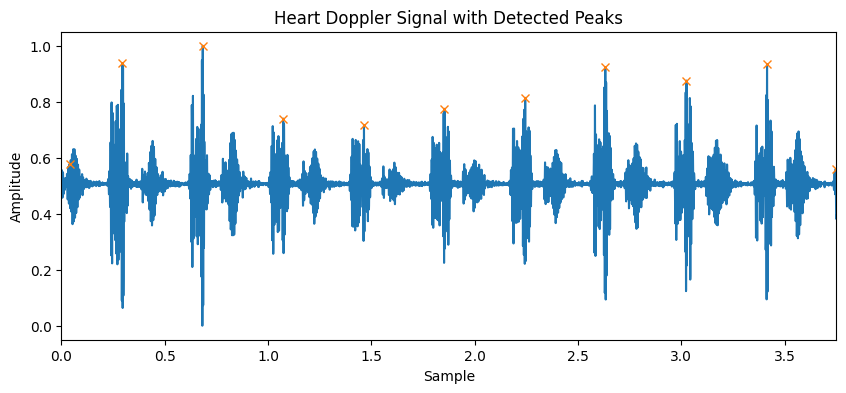

[  40  883 1679 2488 3307 4111 4919 5736 6518 7351]


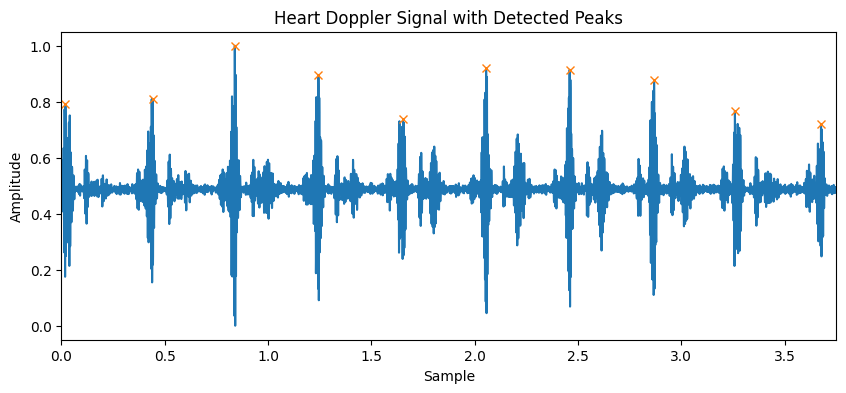

[ 276 1113 1918 2736 3546 4346 5178 5977 6771 7451]


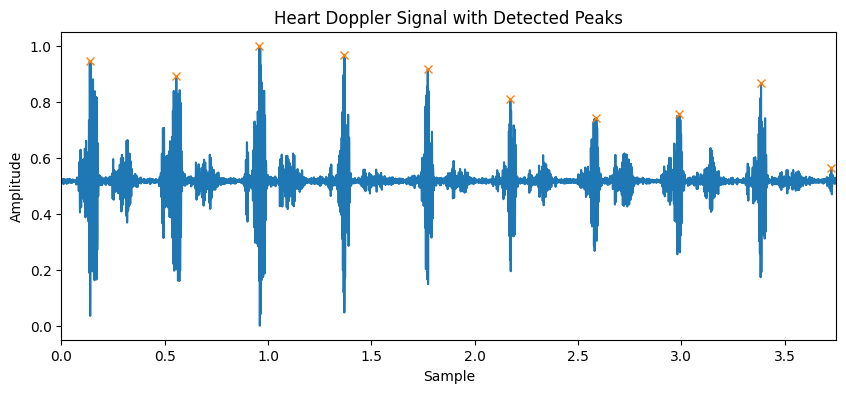

[ 311 1121 1971 2786 3546 4430 5251 6041 6851 7384]


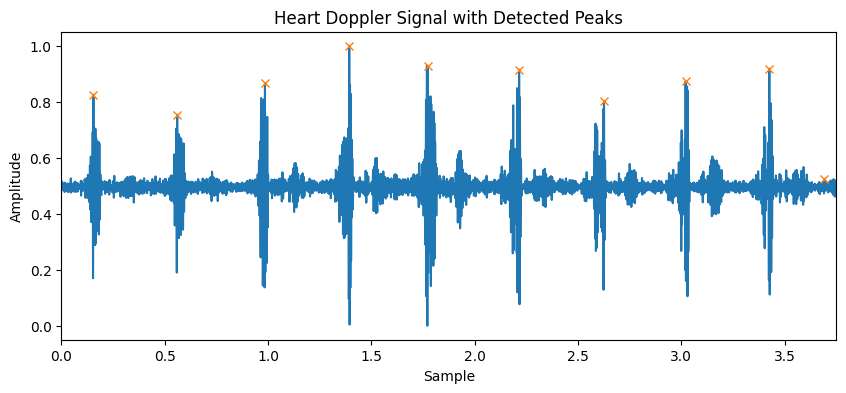

[  20  845 1693 2575 3357 4200 5049 5941 6775 7377]


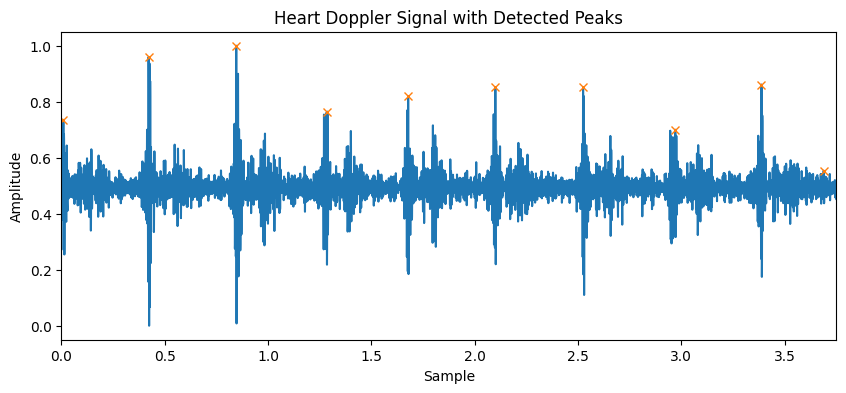

In [25]:
import scipy.signal
fold_index = np.where(label_all[:,1]==0)[0]
indices = fold_index[0:601:30]
for i in indices:
    
    peaks, _ = scipy.signal.find_peaks(DUS_list[i],distance=500)  # Customize parameters as needed
    print(peaks)

# Plotting the signal and the peaks
    plt.figure(figsize=(10, 4))
    t_Doppler = np.linspace(0, 3.75, 7500)
    plt.plot(t_Doppler, DUS_list[i])
    plt.plot(t_Doppler[peaks], DUS_list[i][peaks], "x")
    plt.xlim(0, 3.75)
    plt.title('Heart Doppler Signal with Detected Peaks')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

In [27]:
def plot_signals(indices, DUS_list, ECG_list, tensor_all, beatset_list, label):
    for i in indices:
        # Plot Doppler Signal
        t_Doppler = np.linspace(0, 3.75, 7500)
        plt.figure(figsize=(20, 3))
        plt.plot(t_Doppler, DUS_list[i])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Doppler Signal')
        plt.xlim(0, 3.75)
        for timestamp in beatset_list[i]:
            plt.axvline(x=timestamp, color='r', linestyle='--')
        plt.show()

        # Plot ECG Signal
        t_ECG = np.linspace(0, 3.75, 3750)
        plt.figure(figsize=(20, 3))
        plt.plot(t_ECG, ECG_list[i])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('ECG Signal')
        plt.xlim(0, 3.75)
        for timestamp in beatset_list[i]:
            plt.axvline(x=timestamp, color='r', linestyle='--')
        plt.show()

        # Plot Scalogram
        fs = 4000
        t = np.linspace(0, 3.75, 250)
        scales = np.arange(1, 41)
        fc = pywt.central_frequency('morl')
        frequencies = fc * fs / scales
        plt.figure(figsize=(20, 3))
        plt.imshow(tensor_all[i].T, extent=[t[0], t[-1], 0, len(frequencies)-1], aspect='auto', origin='lower')
        yticks = np.arange(0, len(frequencies), 4)
        ytick_labels = [f"{frequencies[j]:.0f}" for j in yticks]
        plt.yticks(np.arange(len(frequencies)), [f"{freq:.0f}" for freq in frequencies])
        plt.yticks(yticks, ytick_labels)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Scalogram')
        plt.gca().invert_yaxis()
        for timestamp in beatset_list[i]:
            plt.axvline(x=timestamp, color='r', linestyle='--')
        plt.show()

        # Play Audio
        audio_array = np.array(DUS_list[i], dtype=float)
        audio_array = audio_array / np.max(np.abs(audio_array))
        display(Audio(audio_array, rate=4000))

        # Print True HR
        print(f"True HR: {label[i][0]/16:.2f}")


In [34]:
fold_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133])

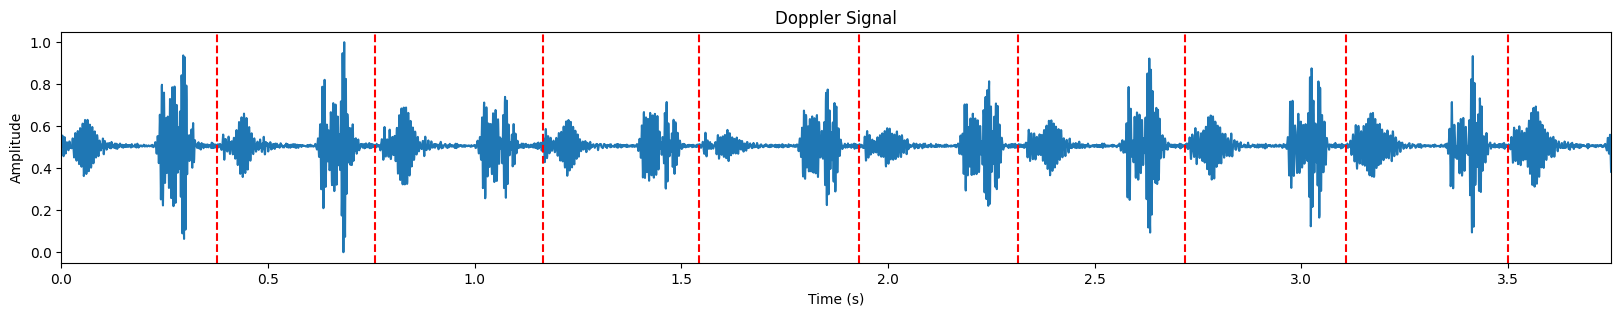

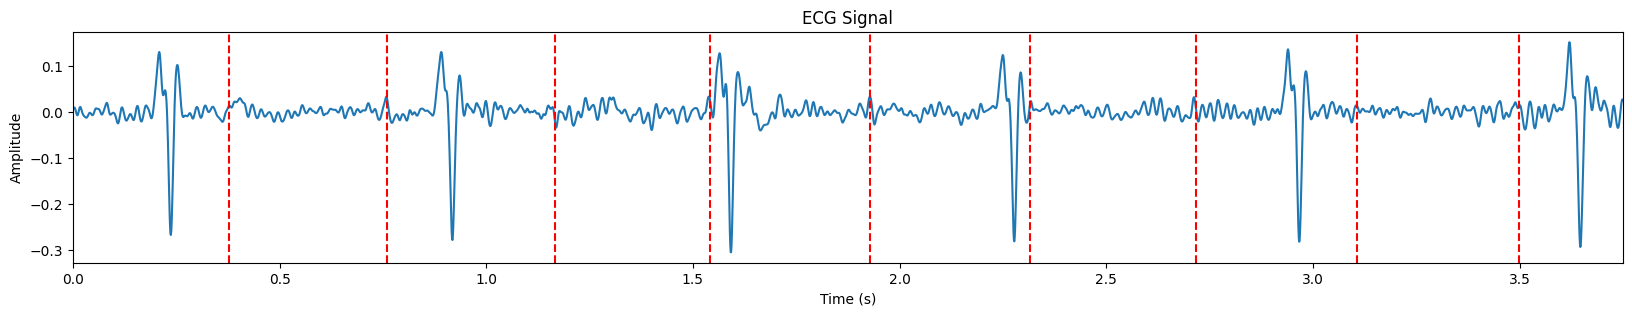

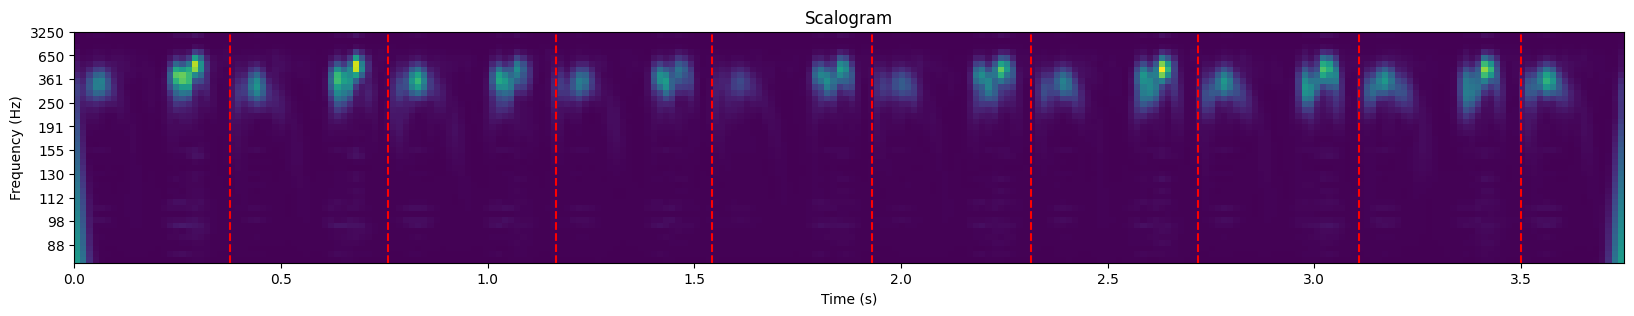

True HR: 9.66


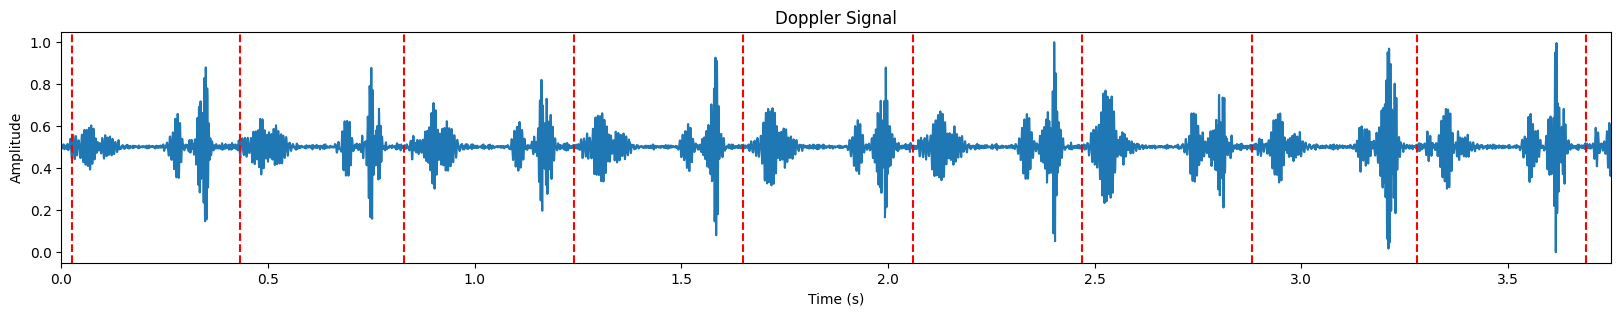

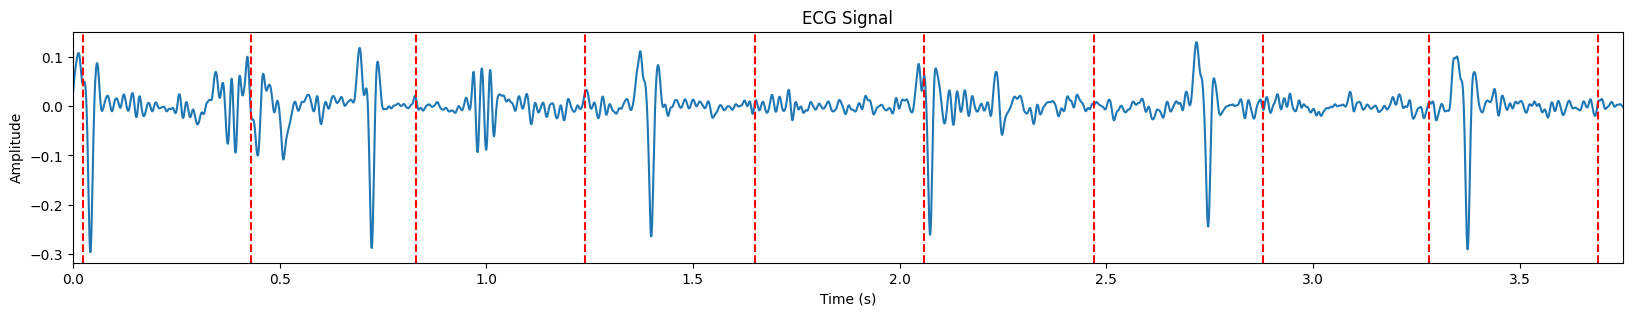

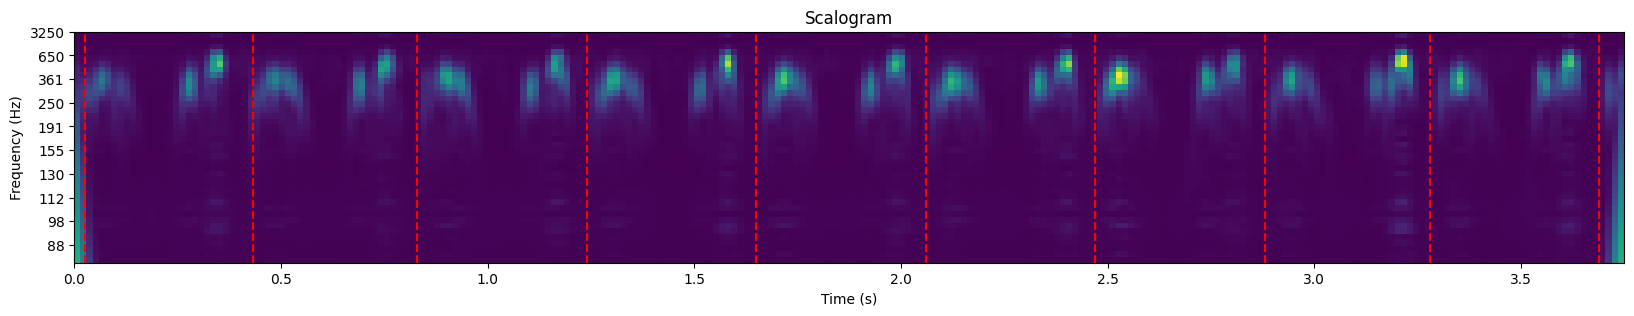

True HR: 9.15


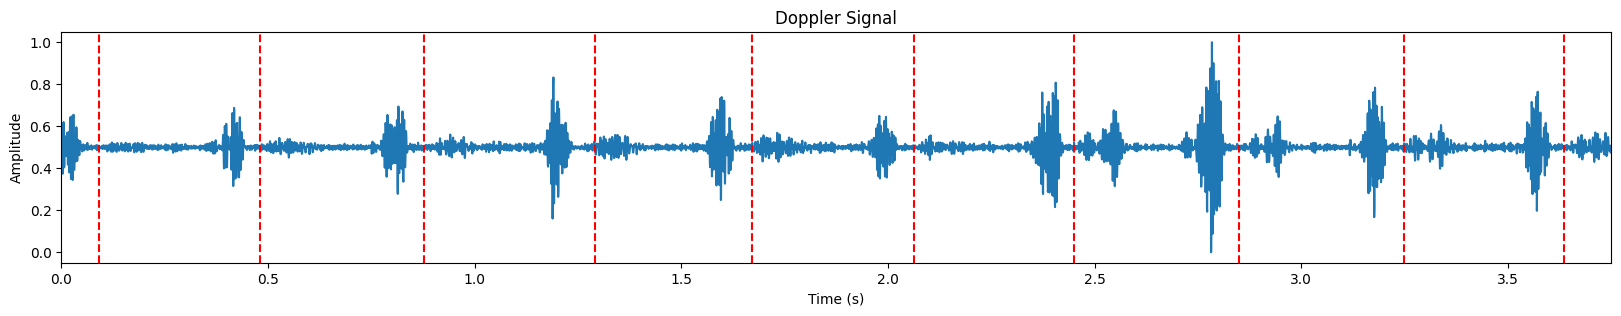

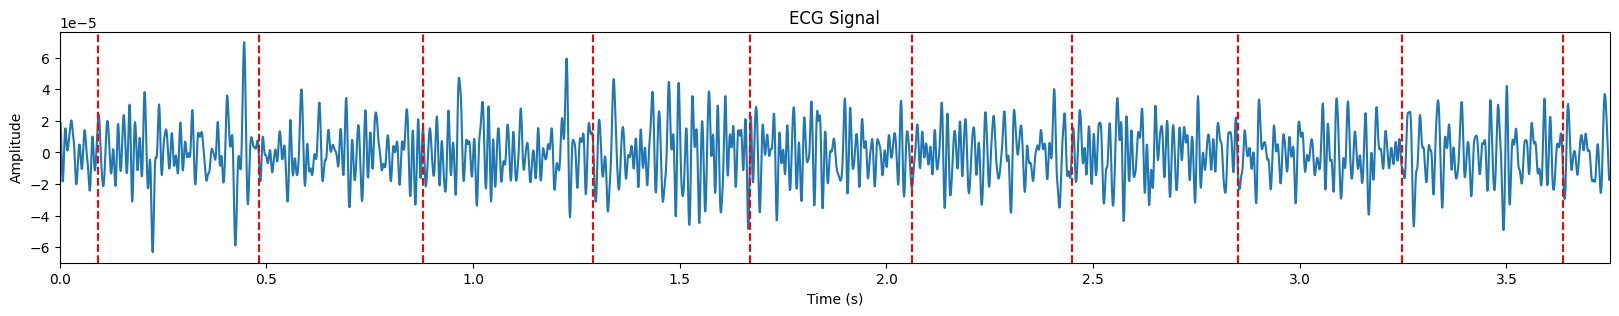

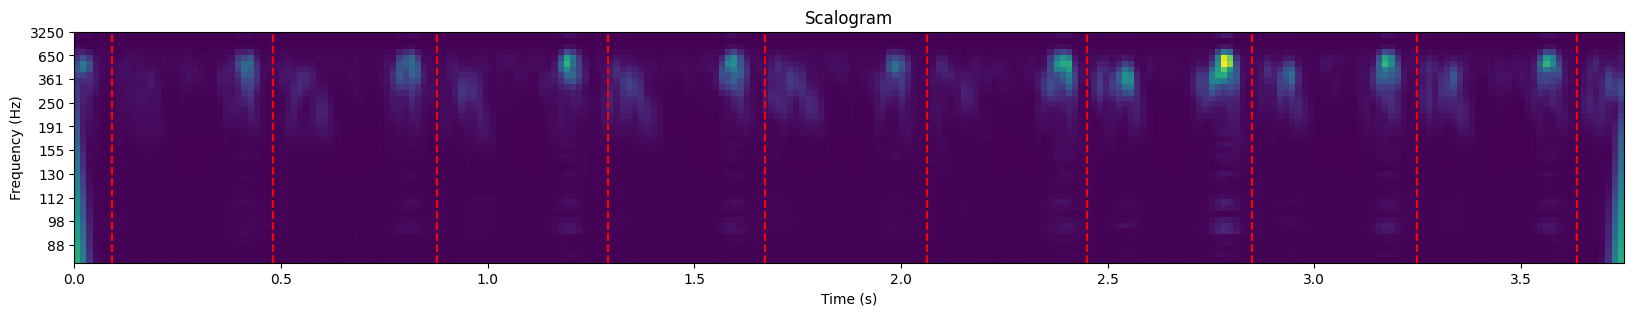

True HR: 9.55


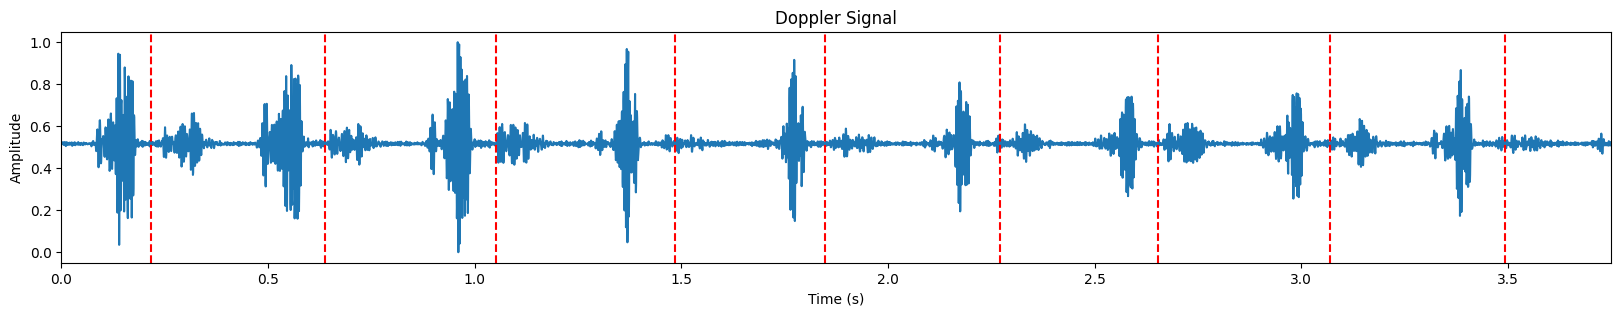

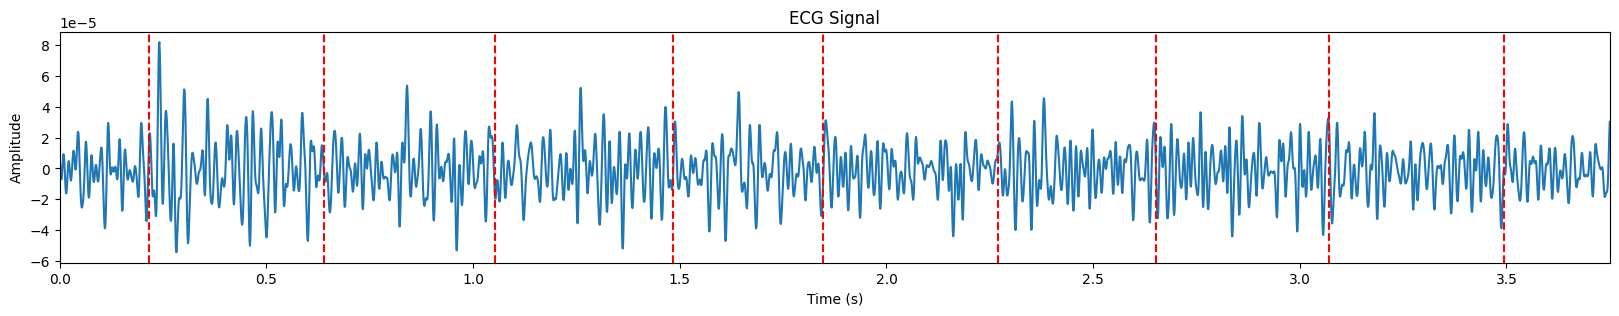

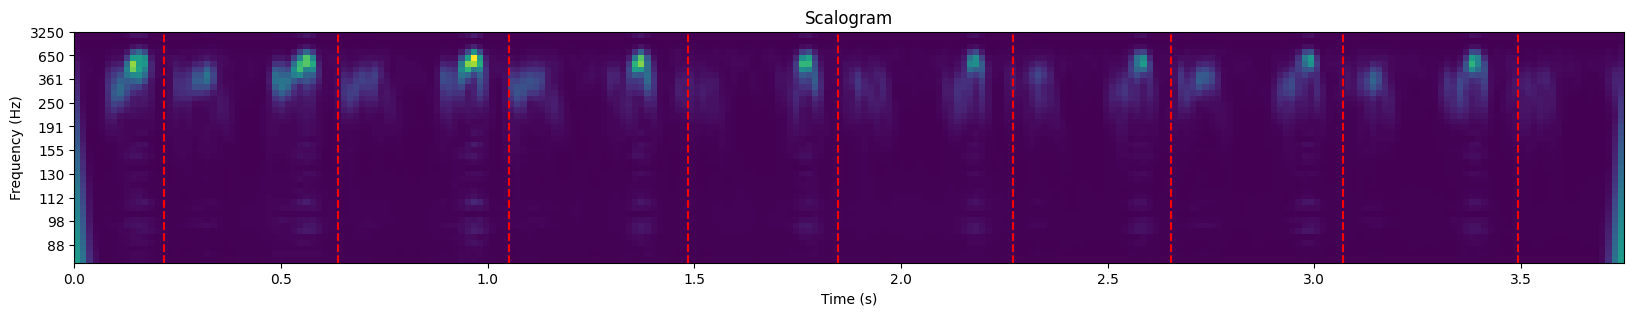

True HR: 8.95


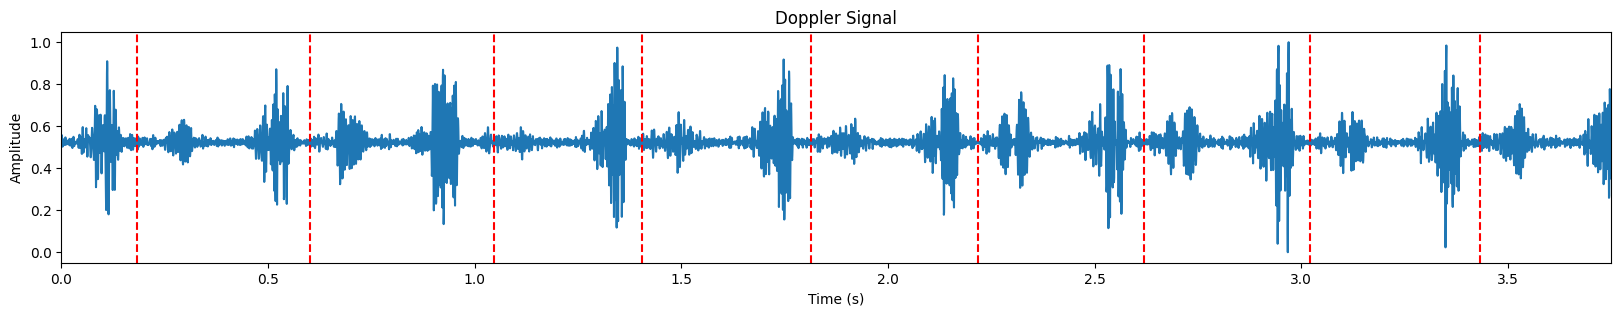

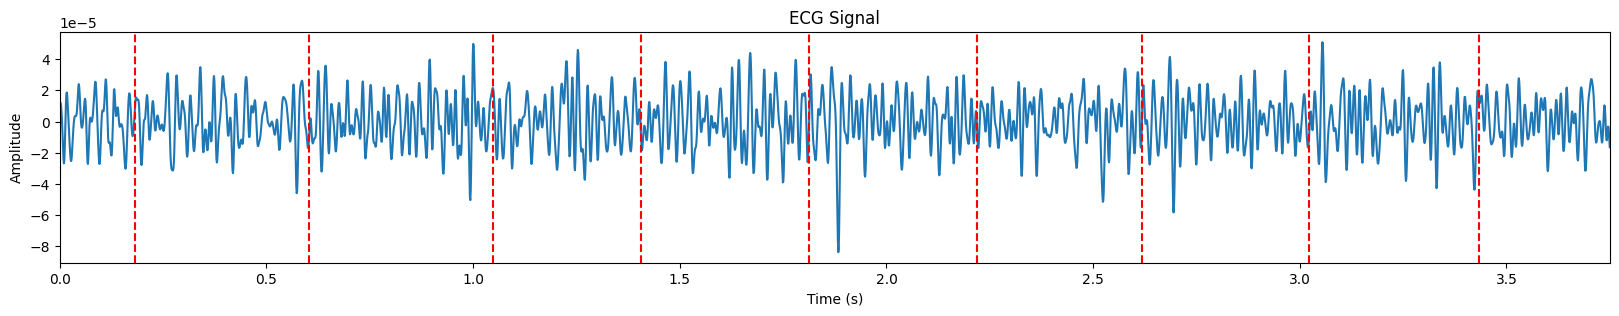

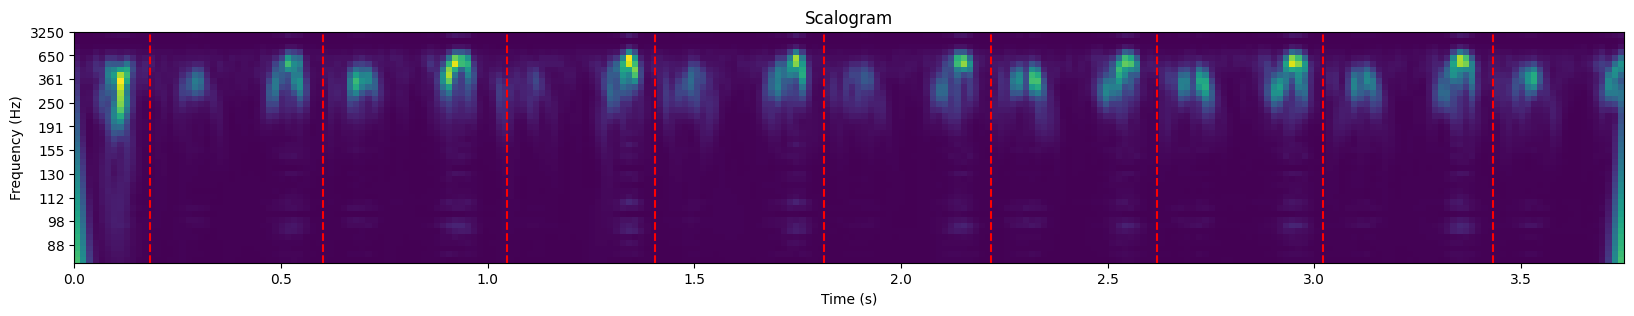

True HR: 9.23


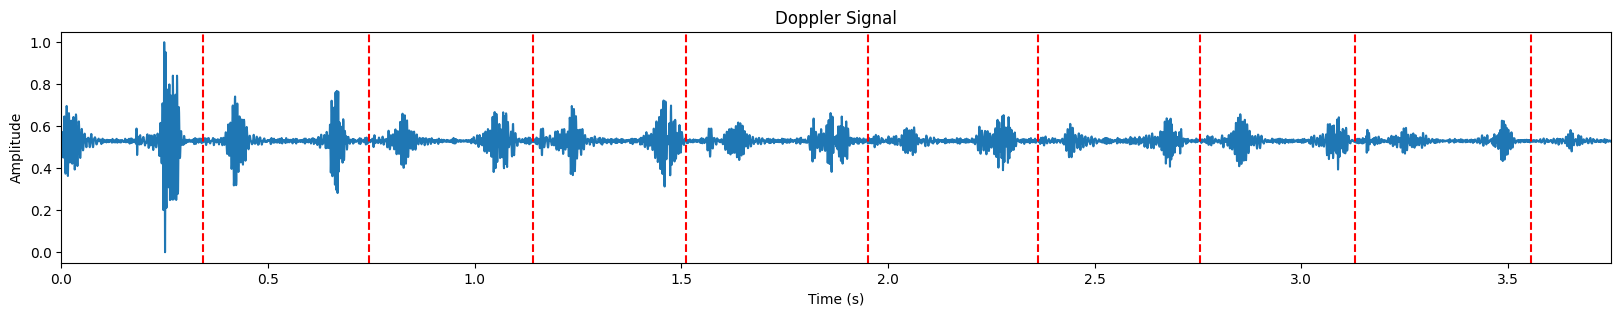

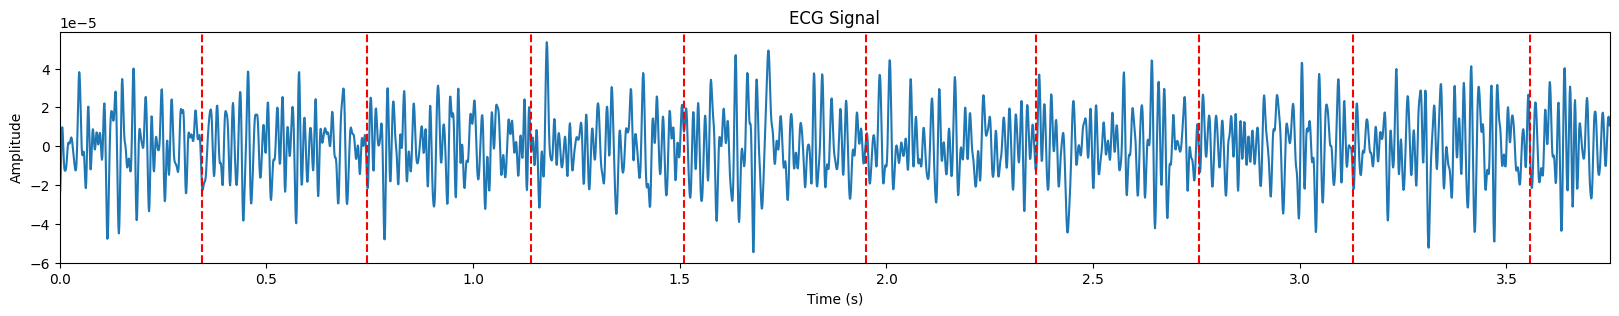

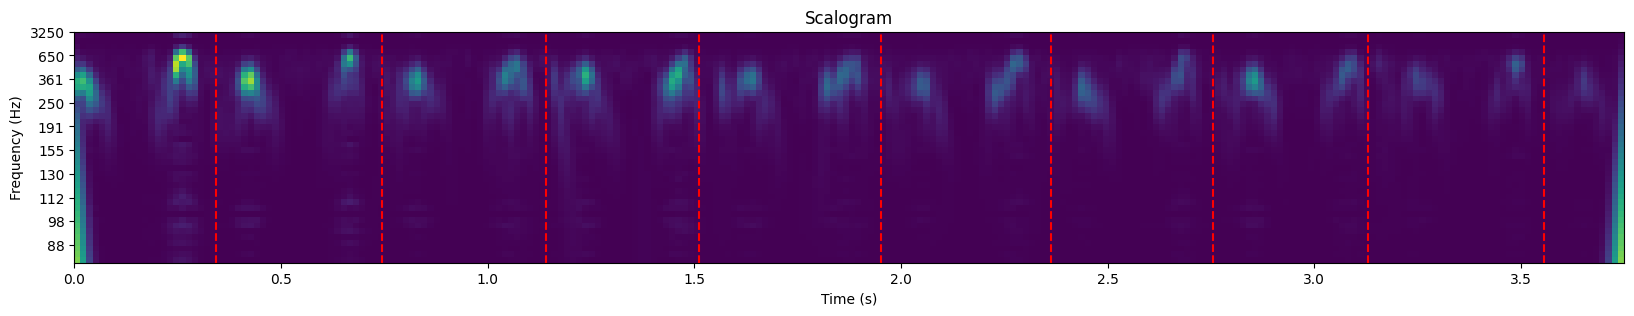

True HR: 9.40


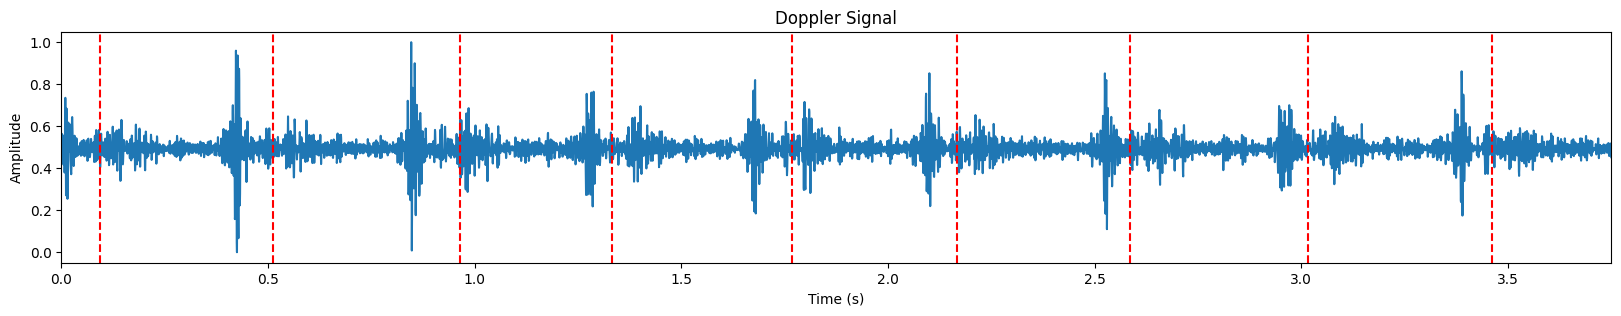

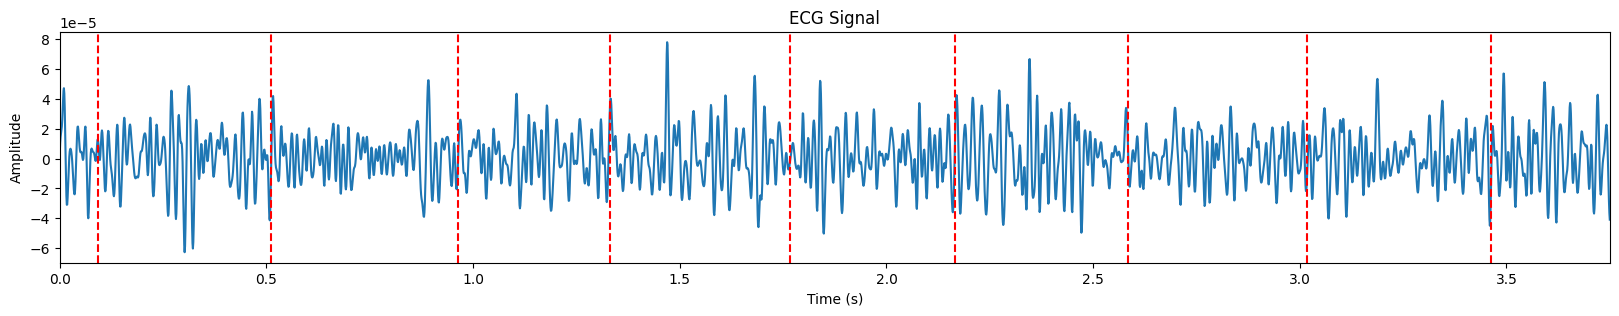

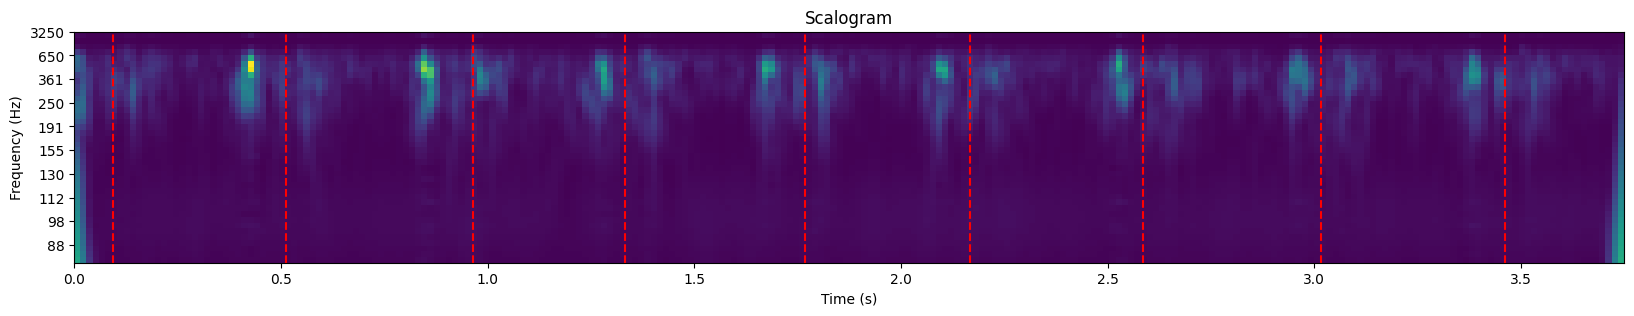

True HR: 8.82


In [28]:
fold_index = np.where(label_all[:,1]==0)[0]
plot_signals(fold_index[0:601:20], DUS_list, ECG_list, tensor_all, beatset_list, label_all)

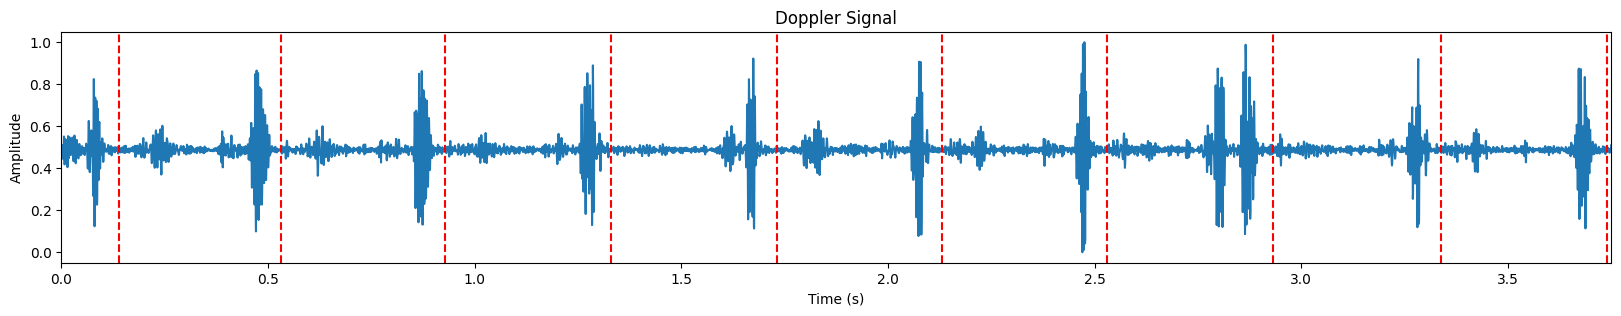

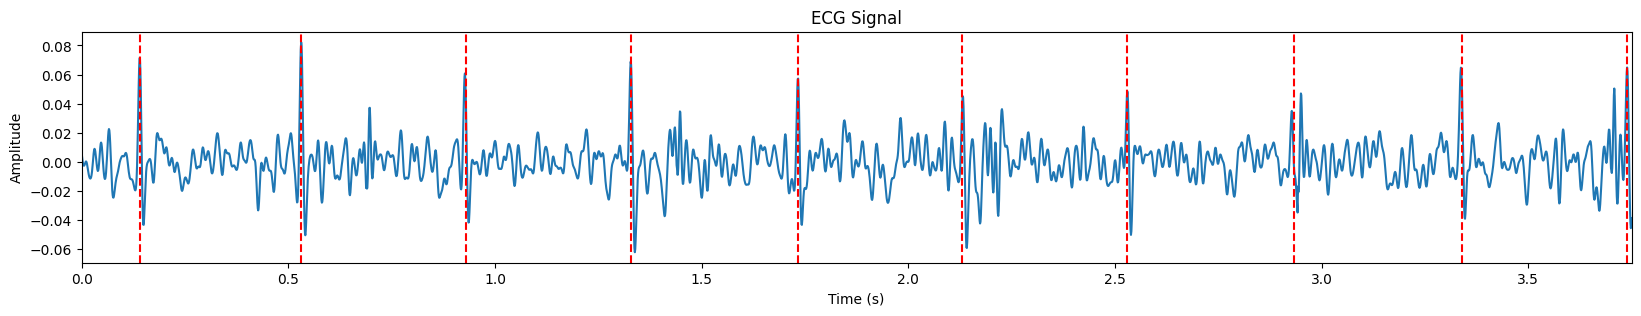

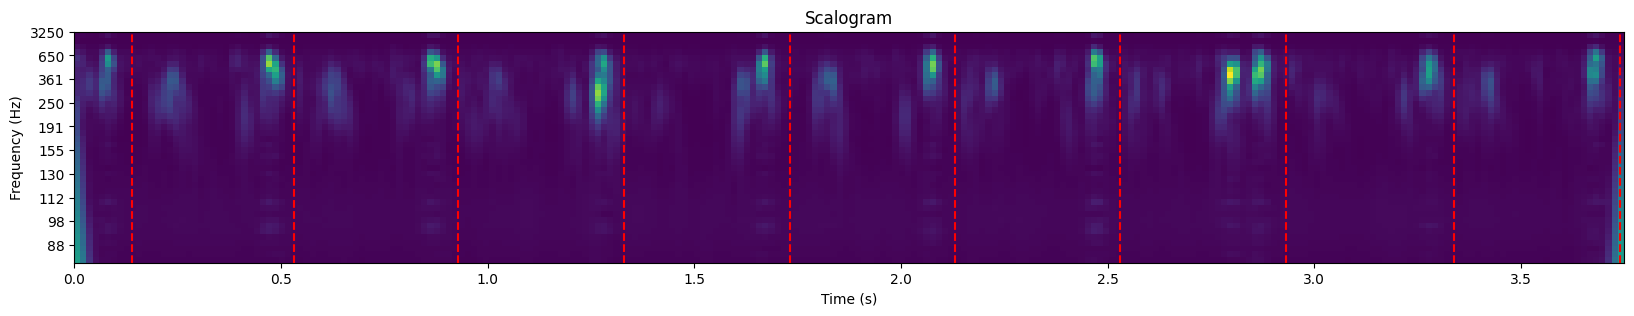

True HR: 9.36


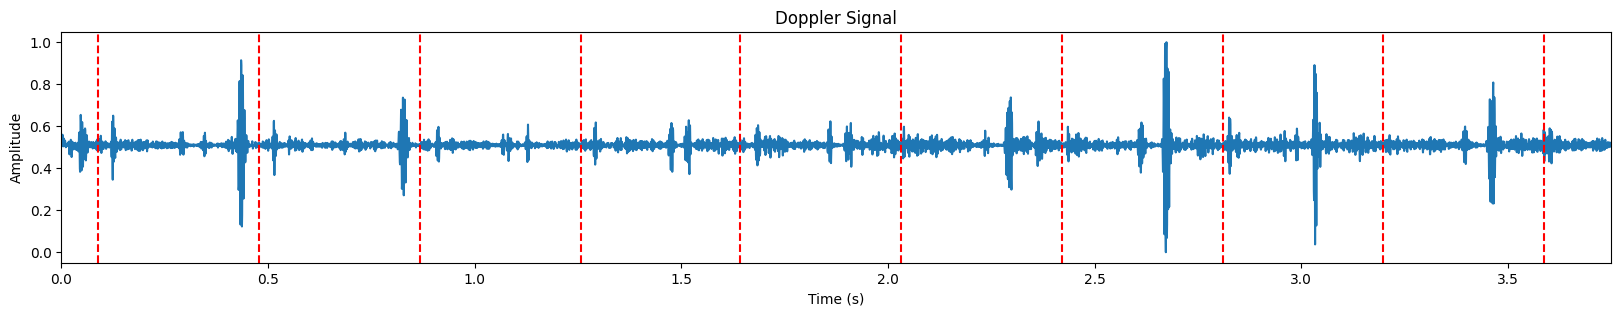

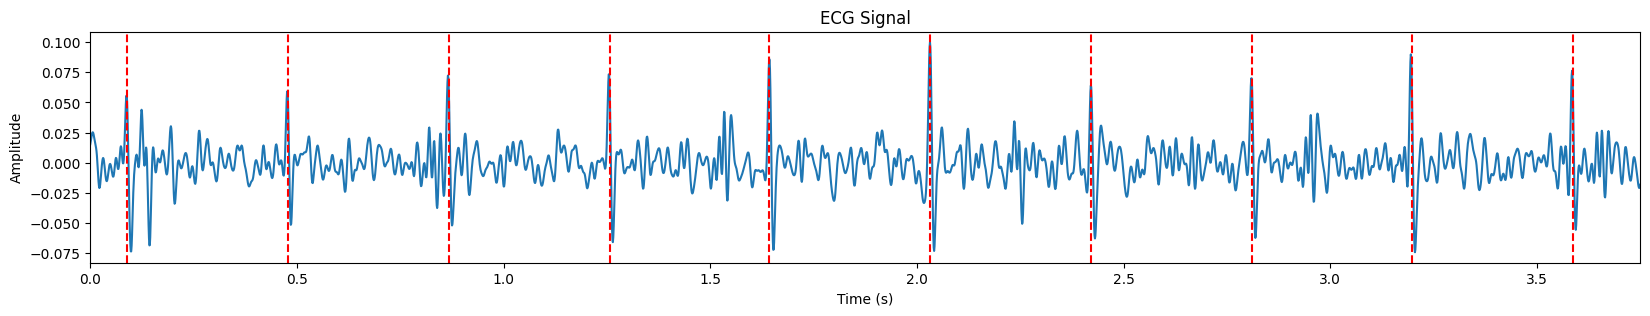

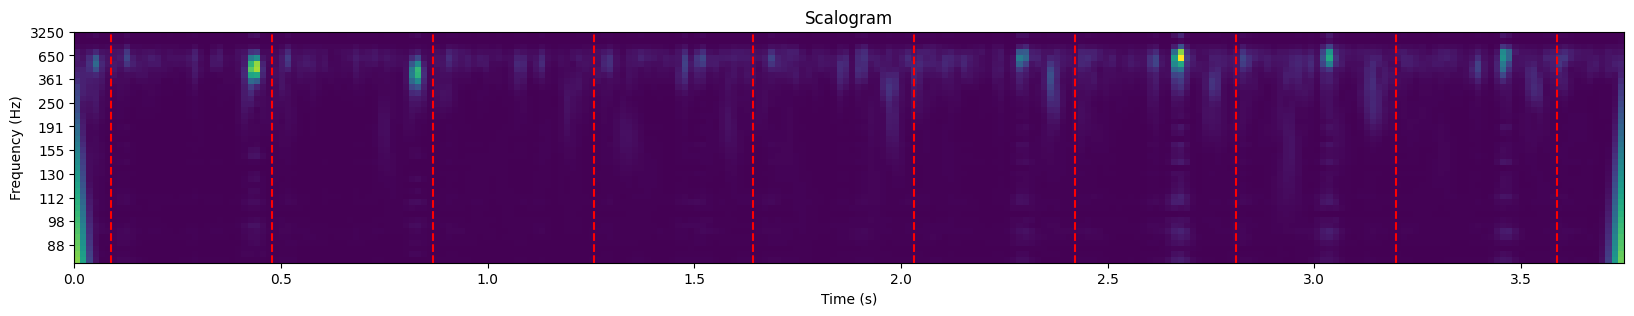

True HR: 9.63


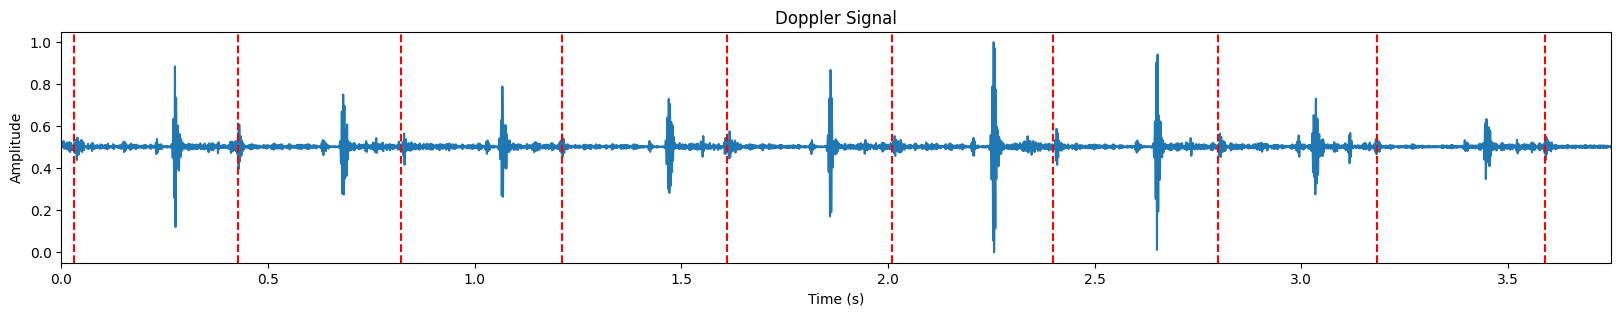

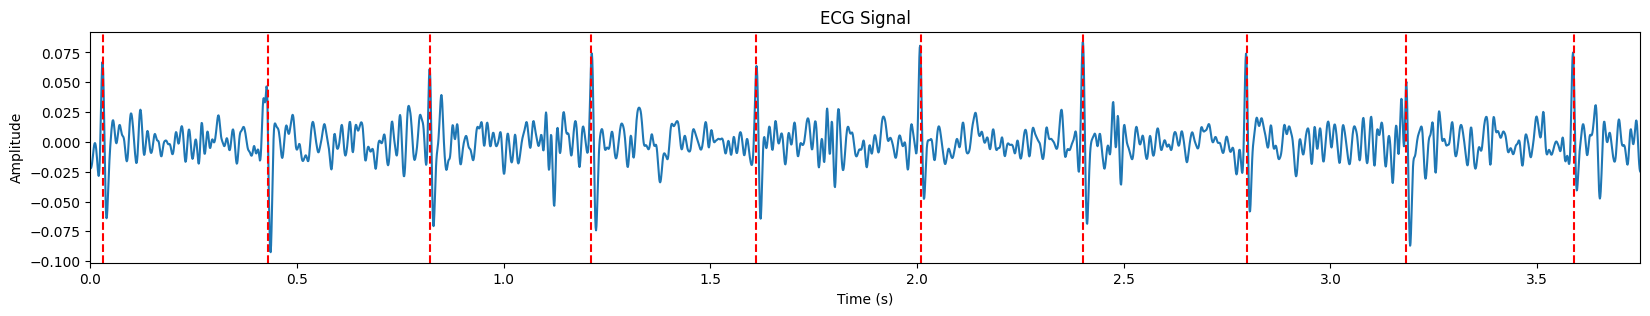

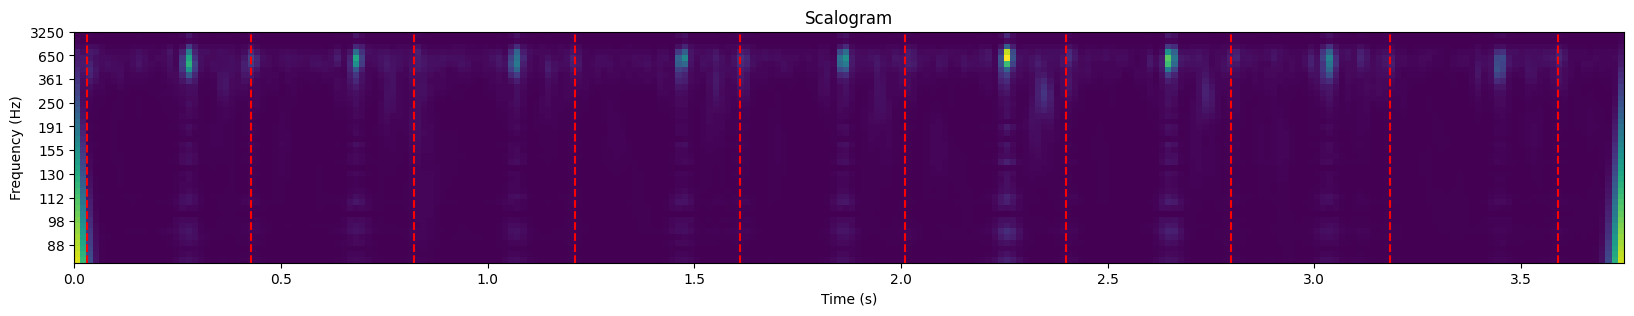

True HR: 9.43


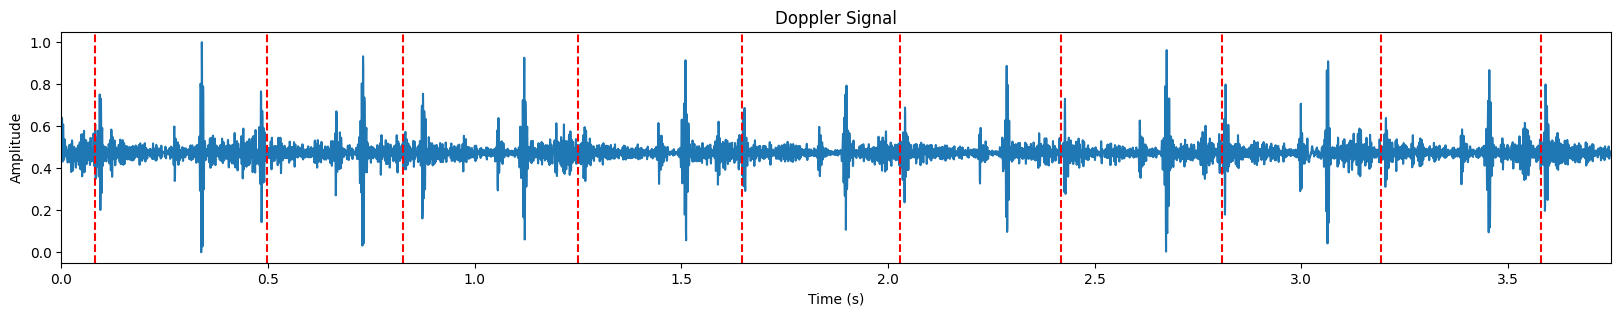

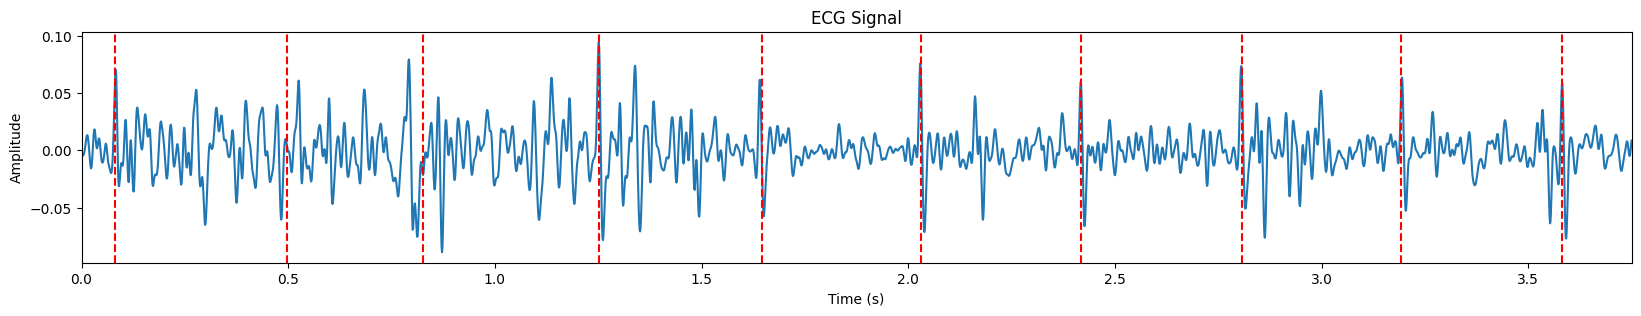

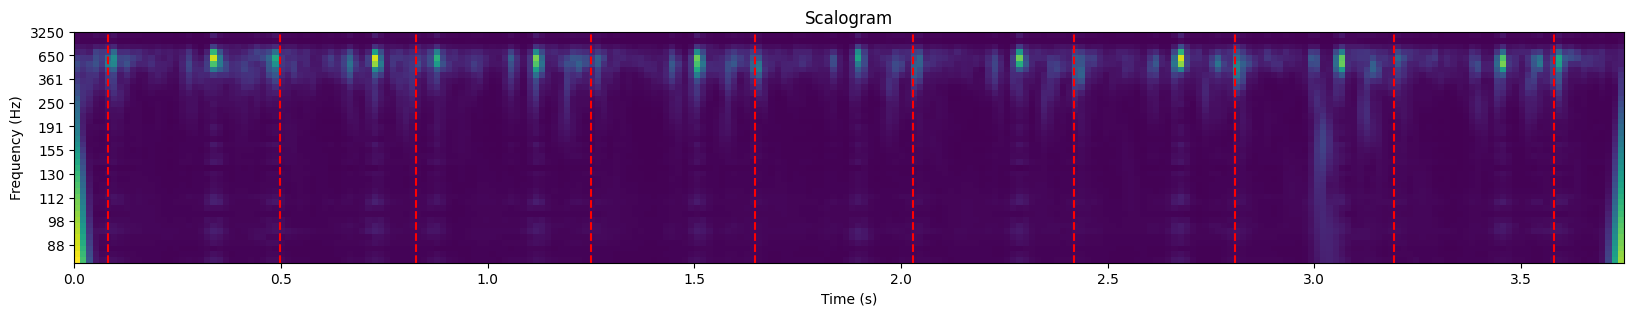

True HR: 9.64


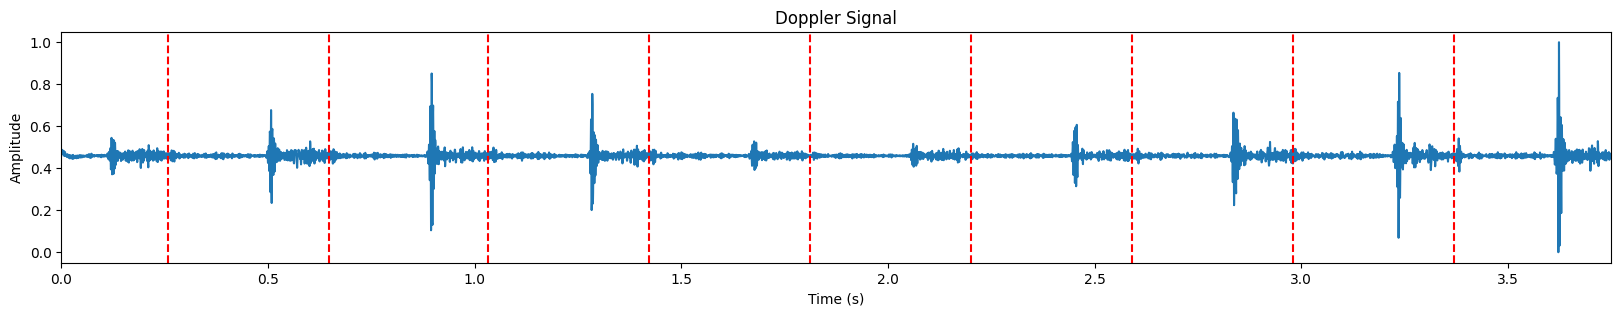

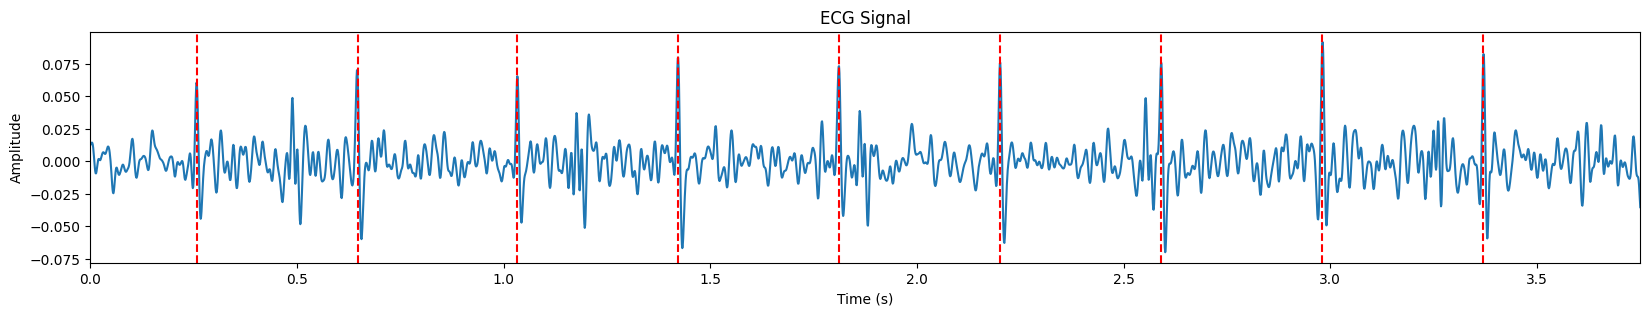

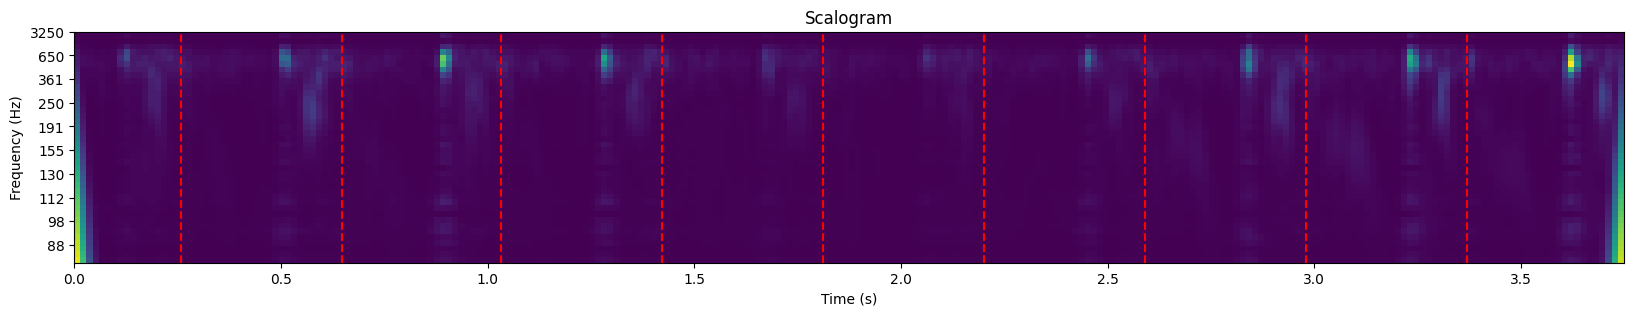

True HR: 9.63


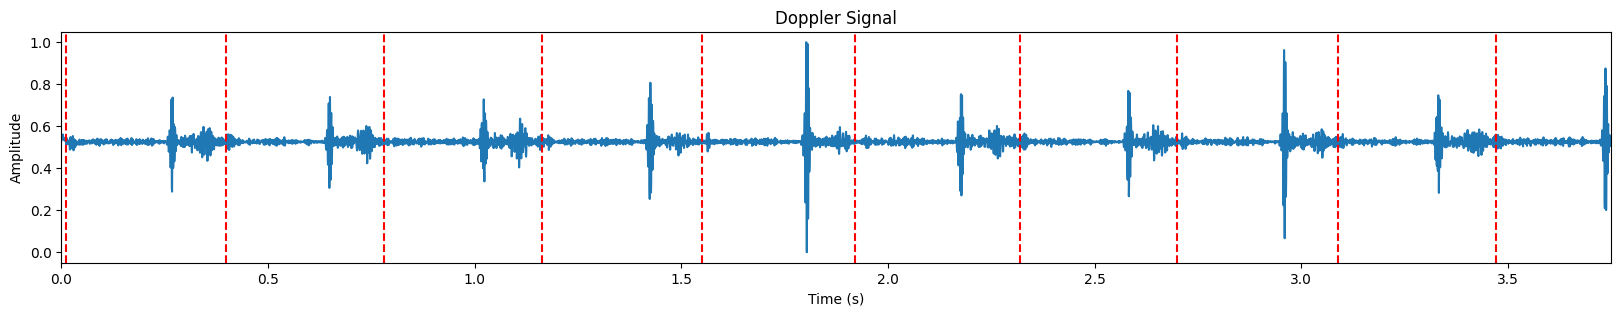

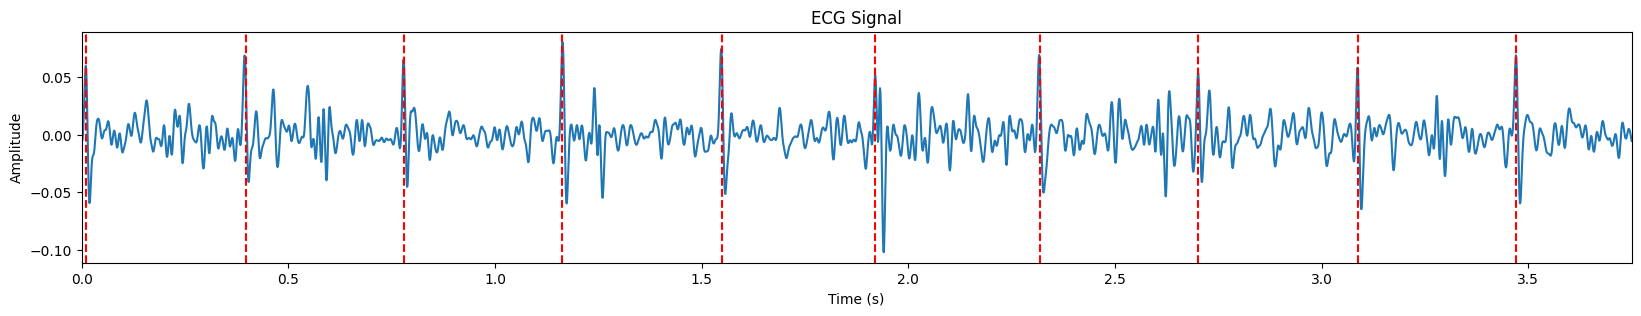

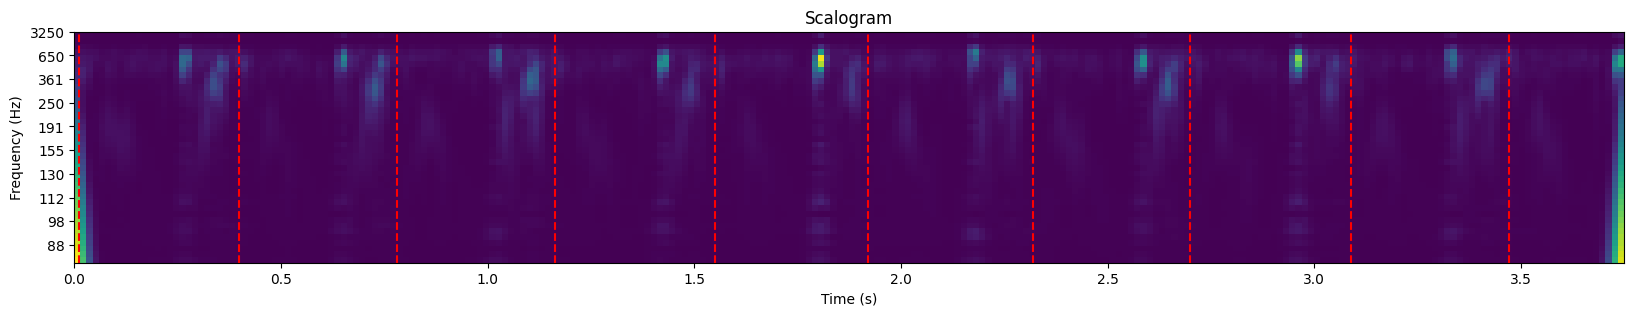

True HR: 9.80


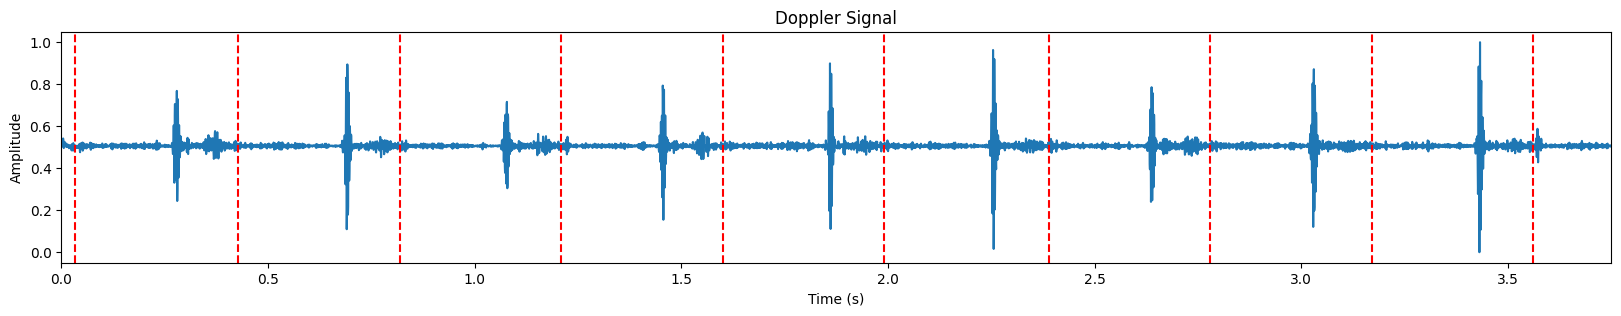

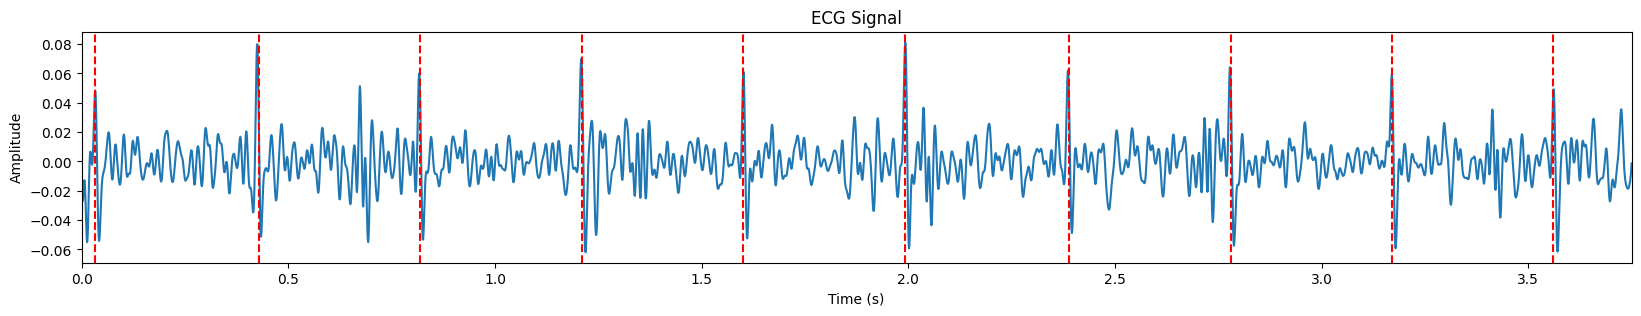

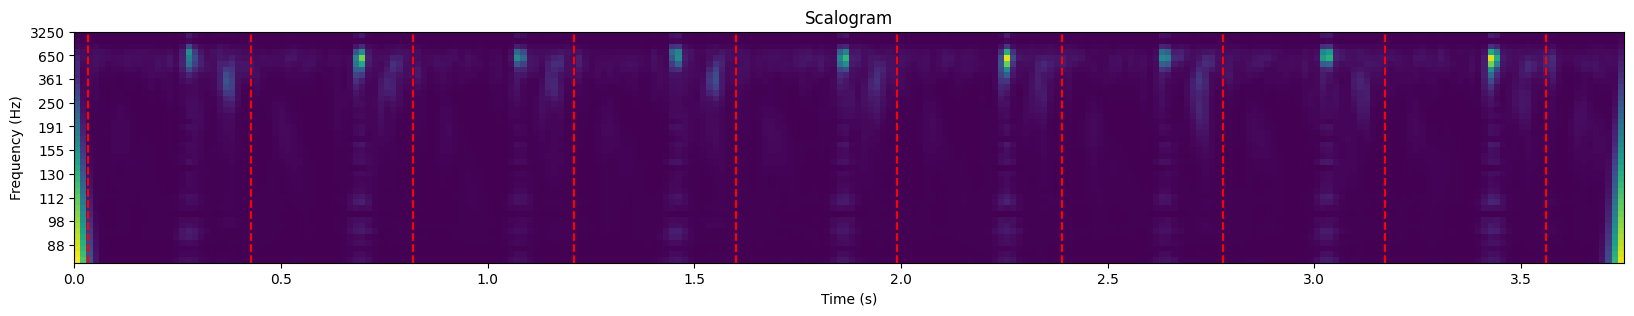

True HR: 9.59


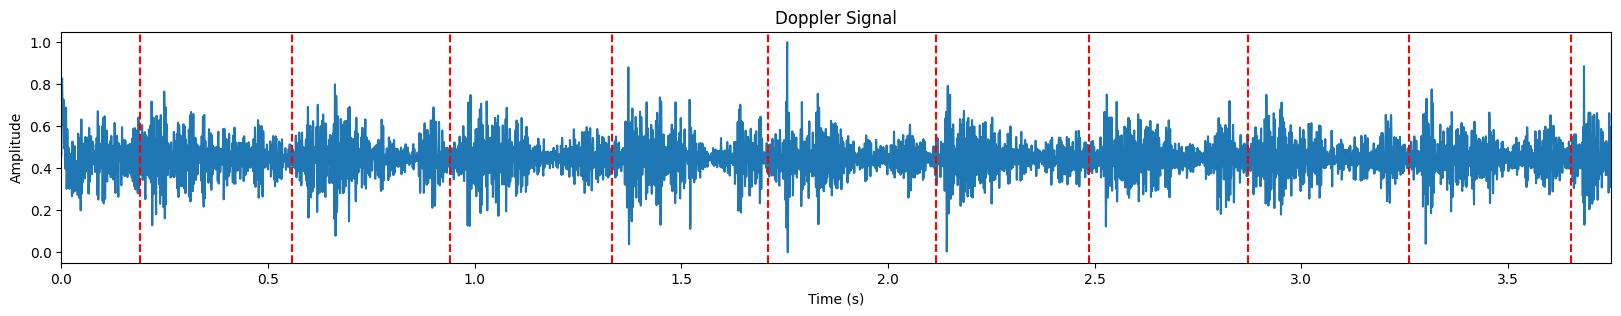

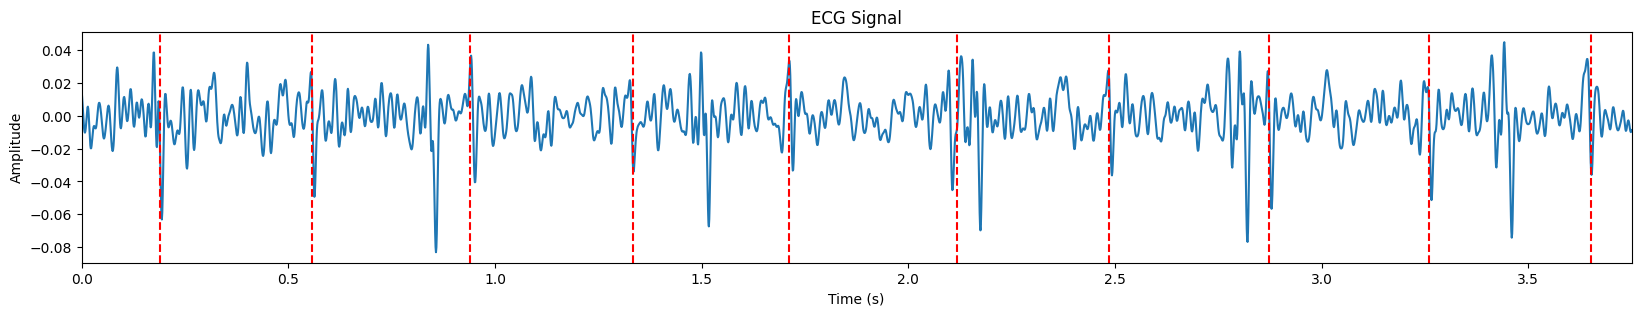

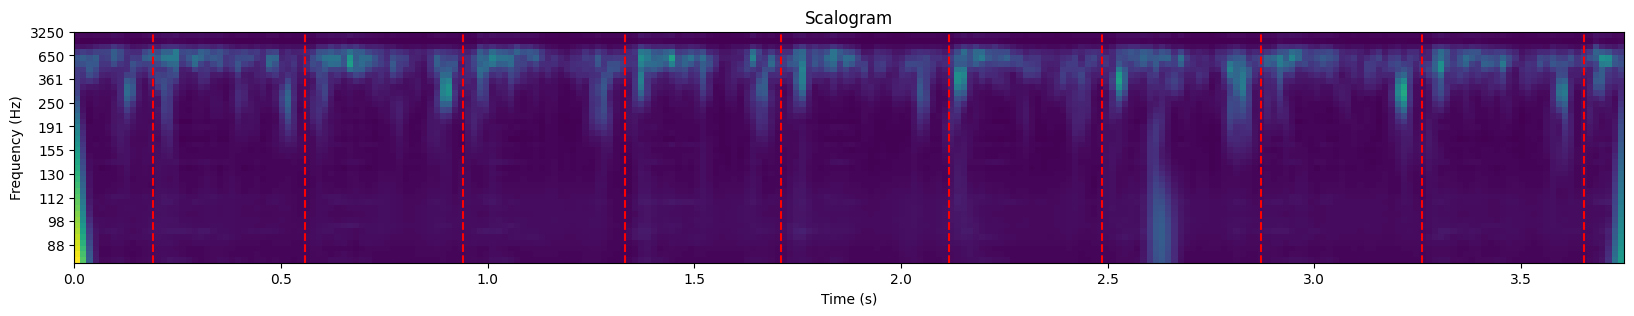

True HR: 9.72


In [29]:
fold_index = np.where(label_all[:,1]==1)[0]
plot_signals(fold_index[0:601:20], DUS_list, ECG_list, tensor_all, beatset_list, label_all)

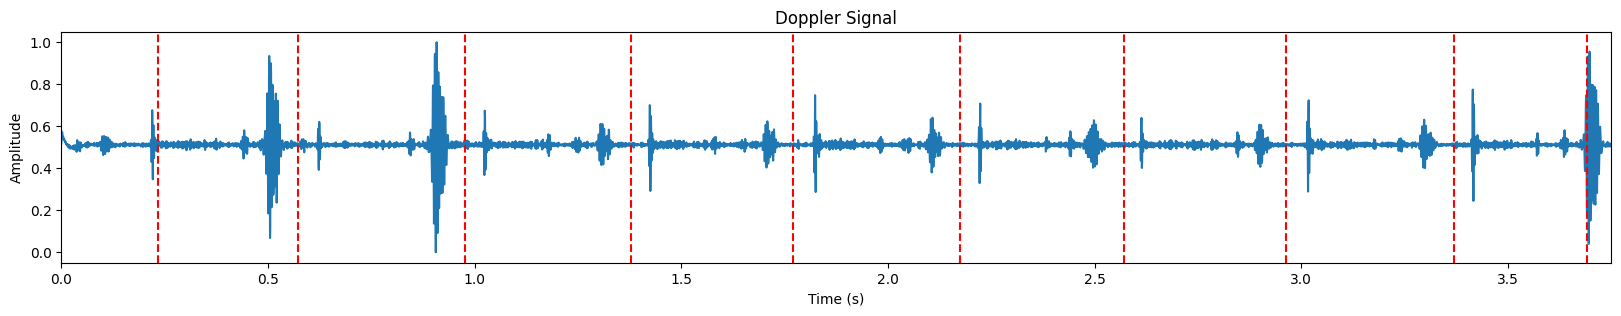

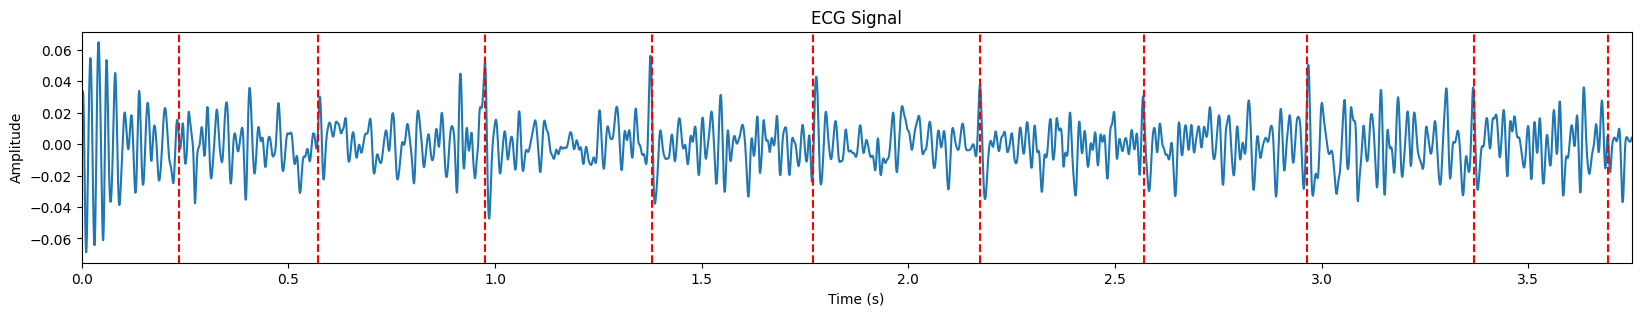

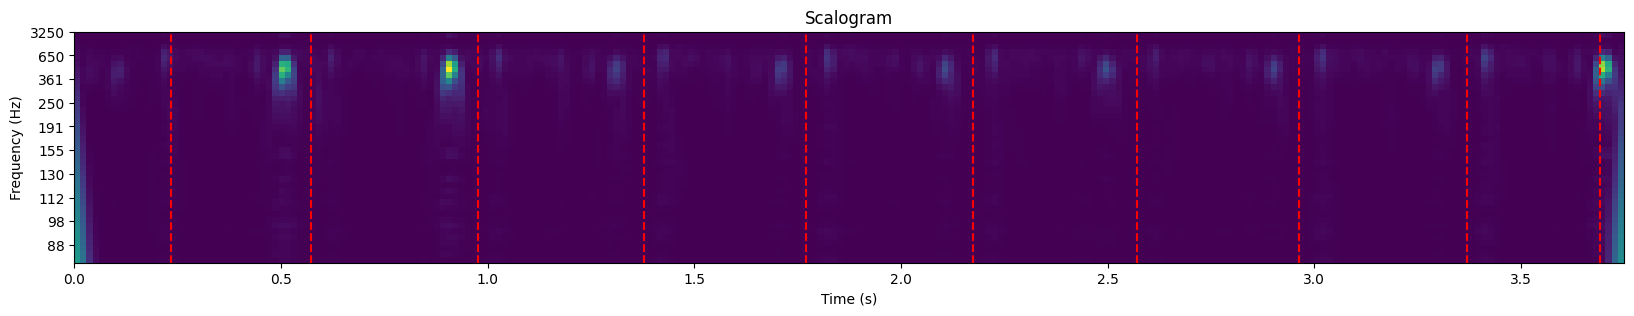

True HR: 9.45


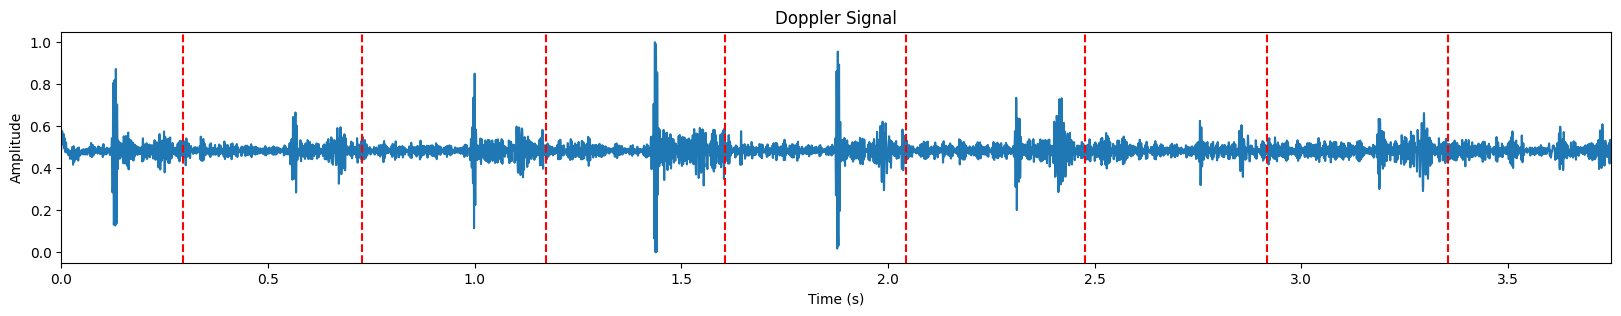

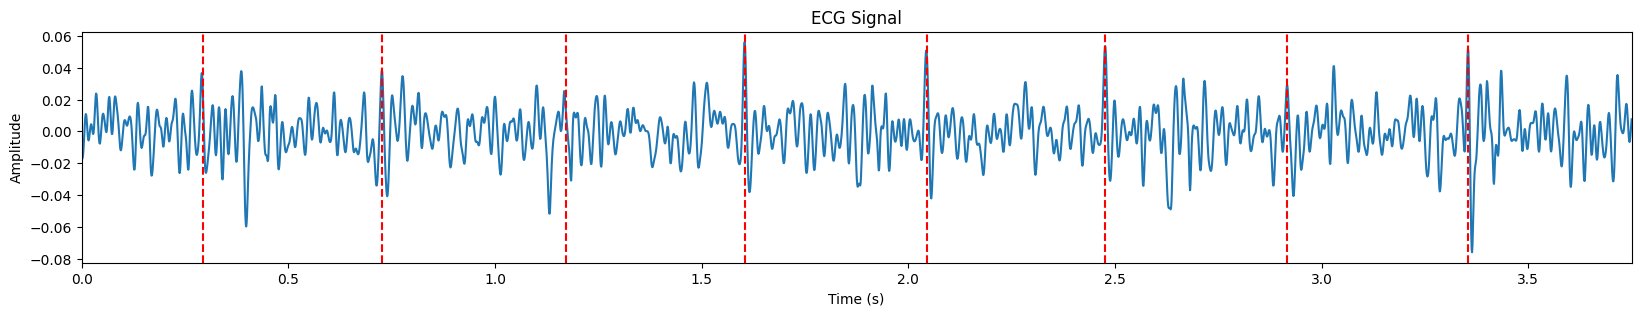

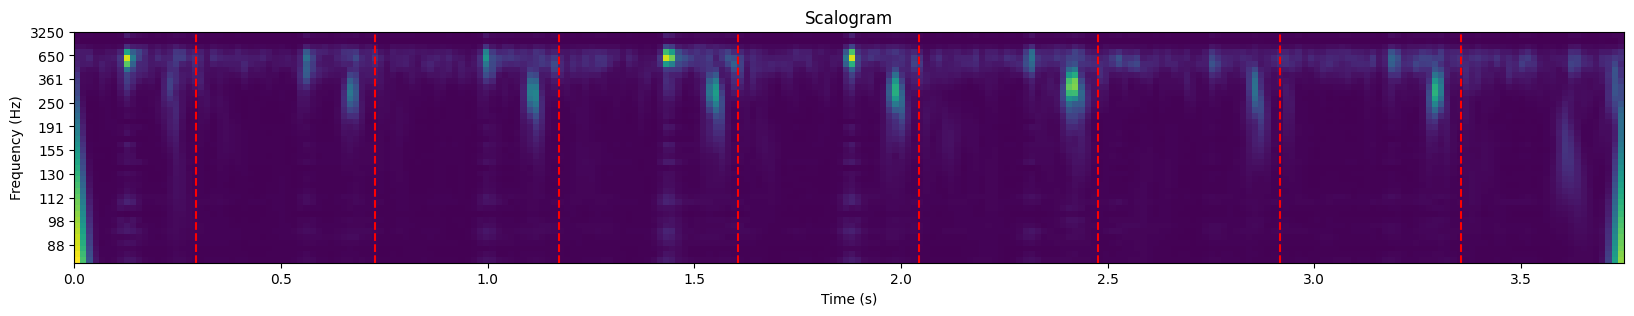

True HR: 8.56


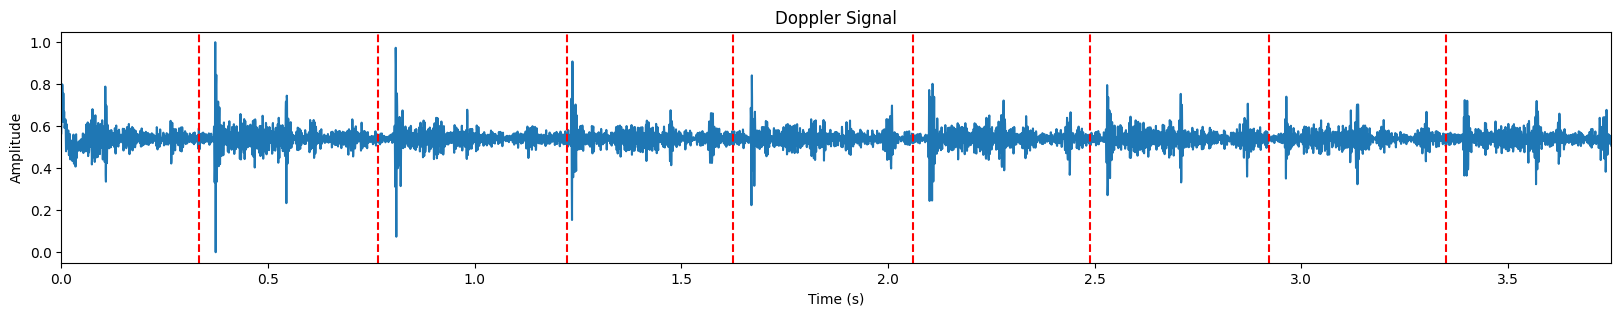

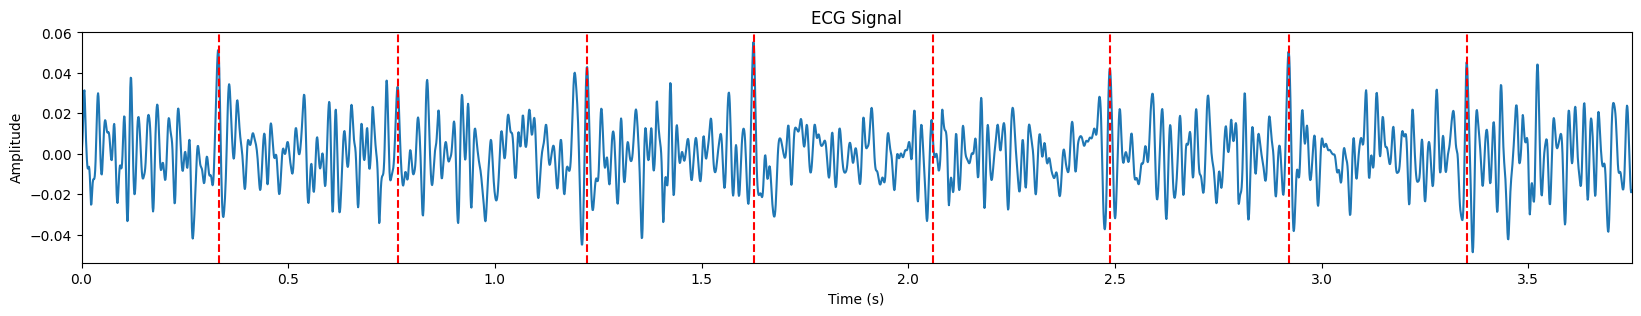

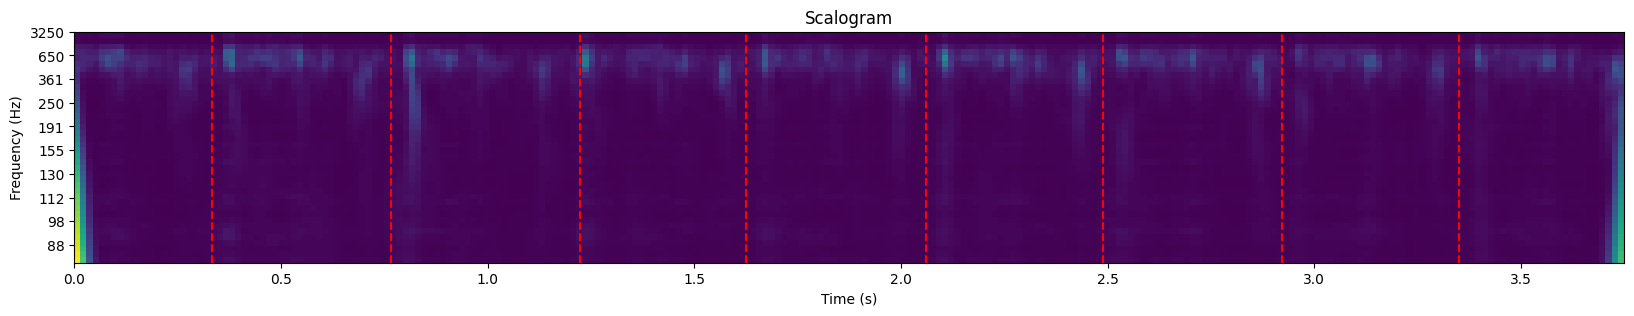

True HR: 8.67


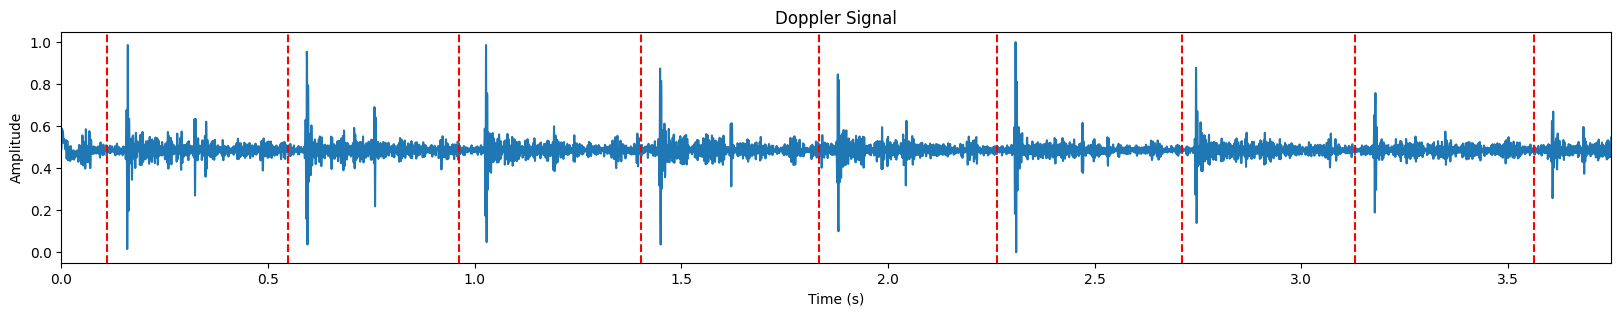

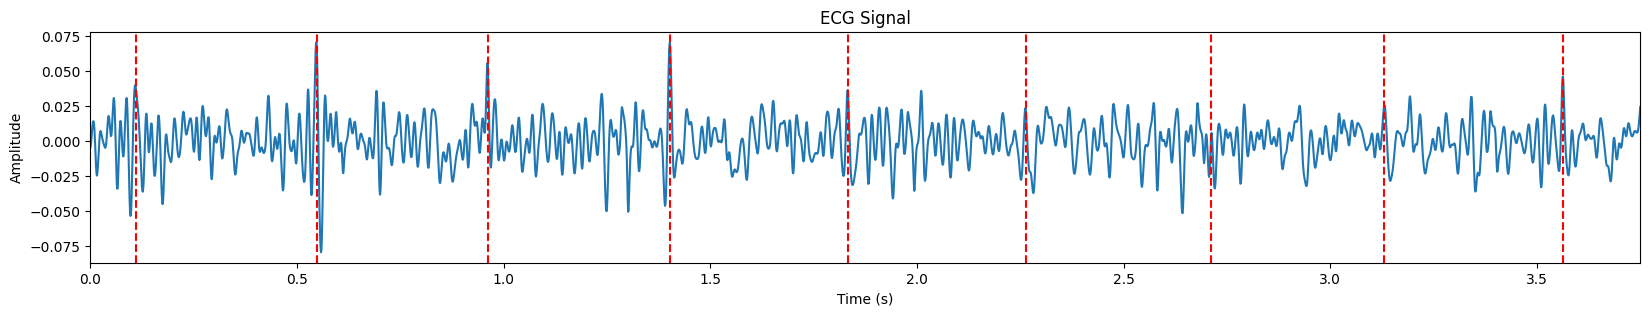

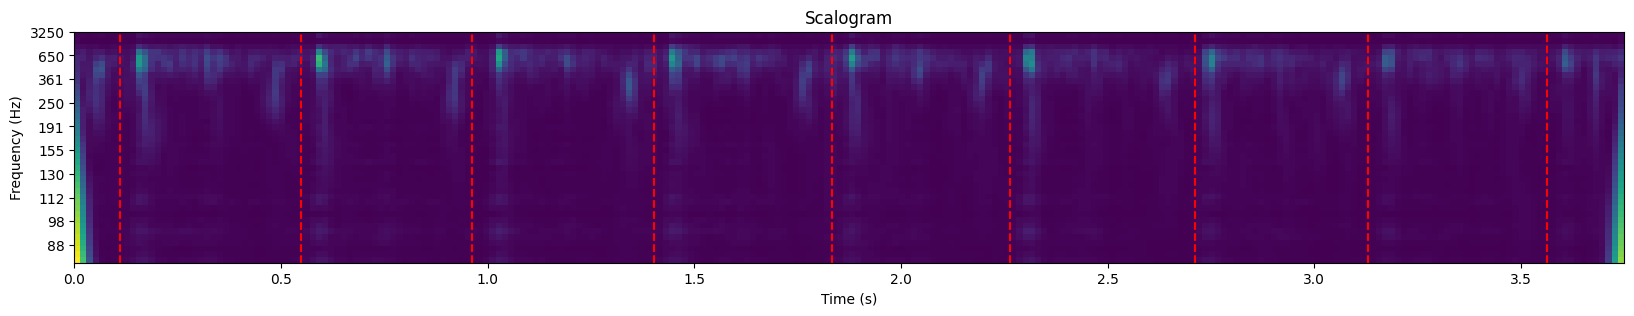

True HR: 8.69


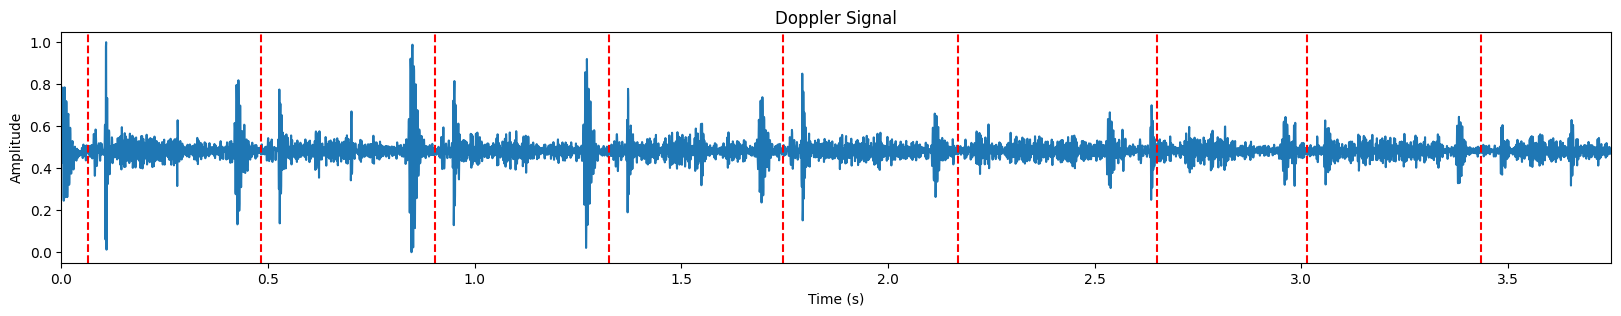

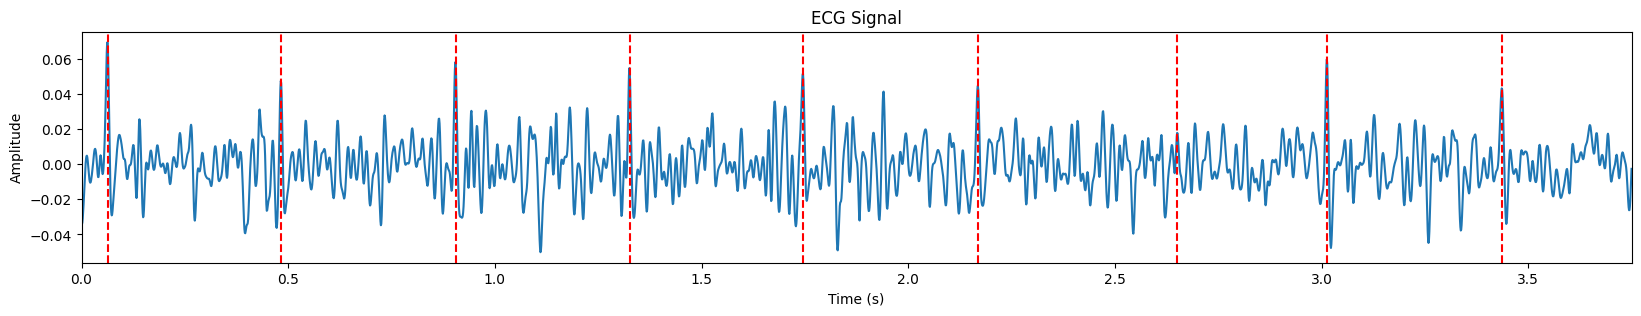

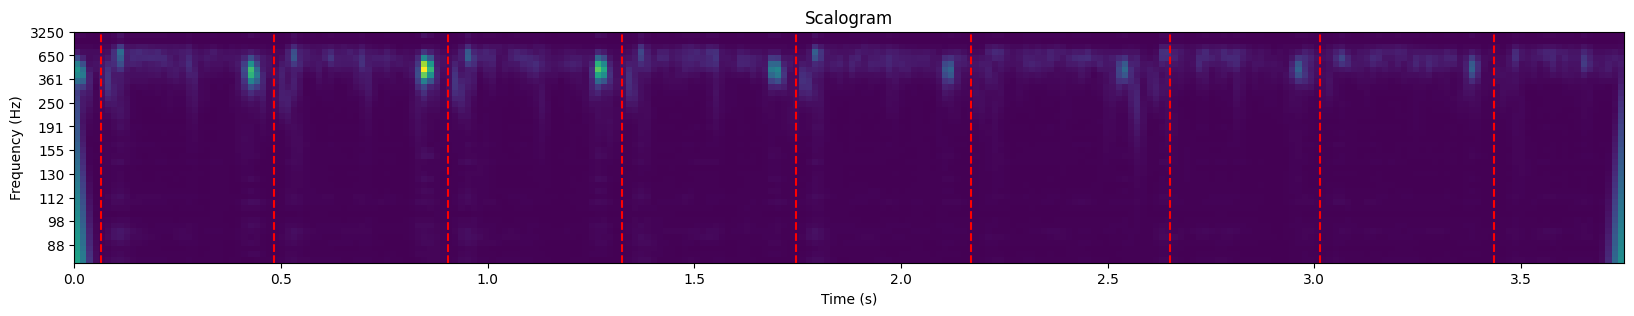

True HR: 8.90


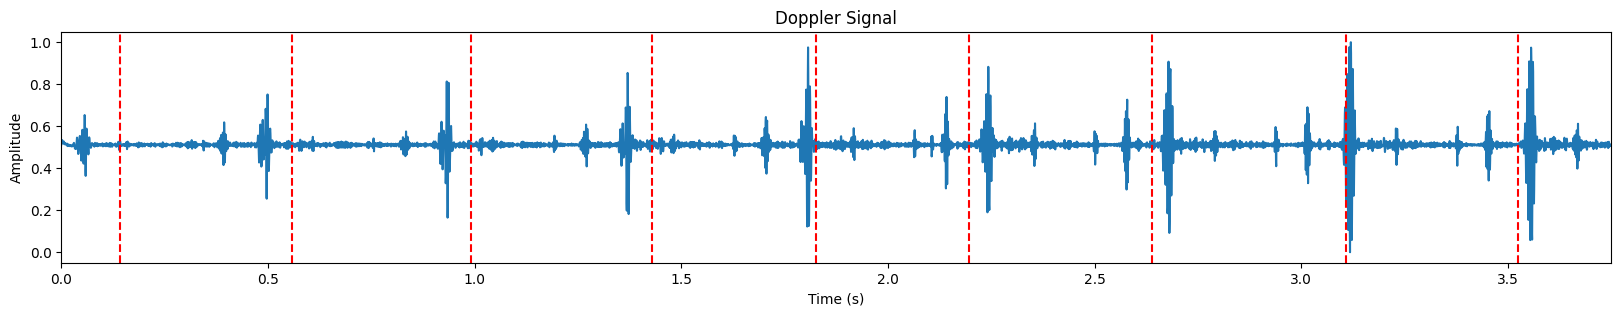

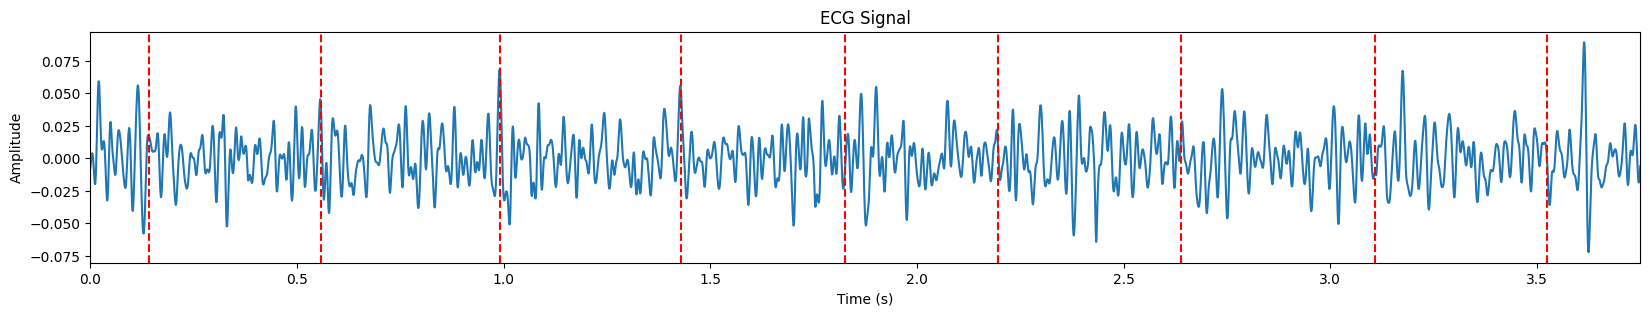

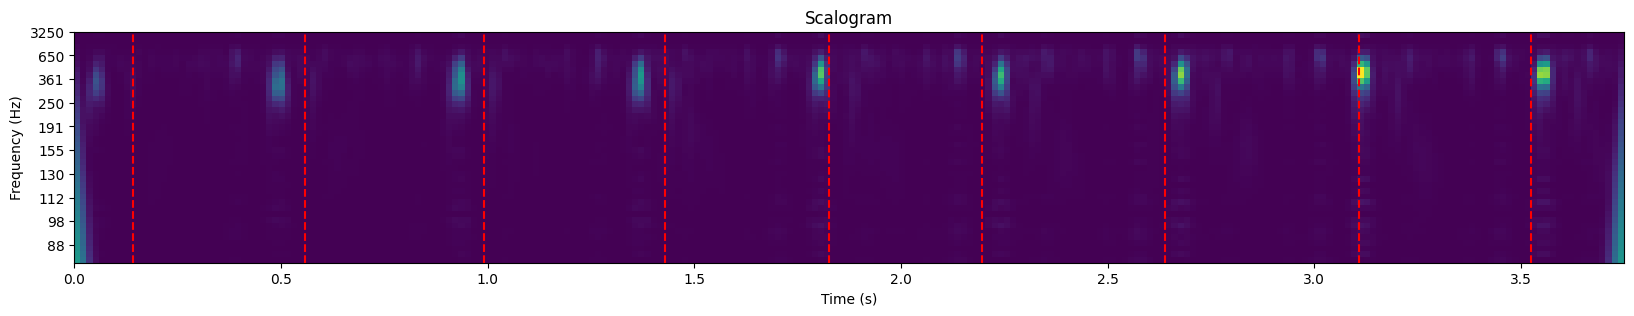

True HR: 8.83


In [35]:
fold_index = np.where(label_all[:,1]==2)[0]
plot_signals(fold_index[0:501:20], DUS_list, ECG_list, tensor_all, beatset_list, label_all)

# Heartbeat extraction

In [29]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_1 = []
ECG_list_1 = []
DUS_list_2 = []
ECG_list_2 = []
DUS_list_3 = []
ECG_list_3 = []
DUS_list_4 = []
ECG_list_4 = []
DUS_list_5 = []
ECG_list_5 = []

DUS_list_train = []
ECG_list_train = []
 
tensor_all_list = []
label_list = []
beatset_list= []
FHR_list= []
DUS_list = []
ECG_list = []
t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(file_names[signal_num])
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments
            

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time

            
            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)

            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])
 
            g_segments += 1
            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            #windowed_rec=normalize_one(windowed_rec)
            
            for i in range(len(beatSet_time)):
                
                if (i == len(beatSet_time) - 2):
                    break
                
                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_2 = find_closest_index(t_Doppler, beatSet_time[i+2])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_2 = find_closest_index(t_ECG, beatSet_time[i+2])


                windowed_rec_beat = windowed_rec[round((i_d_1+i_d)/2):round((i_d_2+i_d_1)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,800)
                
                ECG_beat = ECG[round((i_t_1+i_t)/2):round((i_t_2+i_t_1)/2)]
                ECG_beat=normalize_one(ECG_beat)
                ECG_beat = modify_array(ECG_beat,100)

                #label_windowed_rec[:]=[FHR,signal_num]

                #f=create_scalogram(windowed_rec,target_fs_Doppler,time_bins, freq_bins)
                #f=normalize(f)
                #tensor_rec[0,:,:]=f.T
                if file_names[signal_num]=='AK101197V2':
                    DUS_list_1.append(windowed_rec_beat)
                    ECG_list_1.append(ECG_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_list_2.append(windowed_rec_beat)
                    ECG_list_2.append(ECG_beat)
                               
                if file_names[signal_num]=='MZ290383V2':
                    DUS_list_3.append(windowed_rec_beat)
                    ECG_list_3.append(ECG_beat)
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_list_4.append(windowed_rec_beat)
                    ECG_list_4.append(ECG_beat)
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_list_5.append(windowed_rec_beat)
                    ECG_list_5.append(ECG_beat)

                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_list_train.append(windowed_rec_beat)
                    ECG_list_train.append(ECG_beat)
                    
                #tensor_all_list.append(tensor_rec)
                #label_list.append(label_windowed_rec)
                #FHR_list.append(FHR_all)
                #DUS_list.append(windowed_rec_beat)
                #ECG_list.append(ECG_beat)
                
    #except Exception as e:
        #print(f"Error in {file_names[signal_num]}: {e}")

#tensor_all = np.concatenate(tensor_all_list, axis=0)
#label_all = np.concatenate(label_list, axis=0)
#beatset_list=np.array(beatset_list, dtype=object)
#FHR_list=np.array(FHR_list, dtype=object)
print(g_segments)
DUS_list_1=np.array(DUS_list_1, dtype=object)
ECG_list_1=np.array(ECG_list_1, dtype=object)
DUS_list_2=np.array(DUS_list_2, dtype=object)
ECG_list_2=np.array(ECG_list_2, dtype=object)
DUS_list_3=np.array(DUS_list_3, dtype=object)
ECG_list_3=np.array(ECG_list_3, dtype=object)
DUS_list_4=np.array(DUS_list_4, dtype=object)
ECG_list_4=np.array(ECG_list_4, dtype=object)
DUS_list_5=np.array(DUS_list_5, dtype=object)
ECG_list_5=np.array(ECG_list_5, dtype=object)

DUS_list_train=np.array(DUS_list_train, dtype=object)
ECG_list_train=np.array(ECG_list_train, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_new_1.npz', DUS_list=DUS_list_1, ECG_list=ECG_list_1)
np.savez('./Leipzing_FHR_heartbeat_new_2.npz', DUS_list=DUS_list_2, ECG_list=ECG_list_2)
np.savez('./Leipzing_FHR_heartbeat_new_3.npz', DUS_list=DUS_list_3, ECG_list=ECG_list_3)
np.savez('./Leipzing_FHR_heartbeat_new_4.npz', DUS_list=DUS_list_4, ECG_list=ECG_list_4)
np.savez('./Leipzing_FHR_heartbeat_new_5.npz', DUS_list=DUS_list_5, ECG_list=ECG_list_5)

np.savez('./Leipzing_FHR_heartbeat_new_train.npz', DUS_list=DUS_list_train, ECG_list=ECG_list_train)

8


In [ ]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_1 = []
ECG_list_1 = []
DUS_list_2 = []
ECG_list_2 = []
DUS_list_3 = []
ECG_list_3 = []
DUS_list_4 = []
ECG_list_4 = []
DUS_list_5 = []
ECG_list_5 = []

DUS_list_train = []
ECG_list_train = []
 
tensor_all_list = []
label_list = []
beatset_list= []
FHR_list= []
DUS_list = []
ECG_list = []
t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(file_names[signal_num])
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments
            

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time

            
            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)

            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])
 
            g_segments += 1
            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            #windowed_rec=normalize_one(windowed_rec)
            
            for i in range(len(beatSet_time)):
                
                if (i == len(beatSet_time) - 2):
                    break
                
                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_2 = find_closest_index(t_Doppler, beatSet_time[i+2])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_2 = find_closest_index(t_ECG, beatSet_time[i+2])


                windowed_rec_beat = windowed_rec[round((i_d_1+i_d)/2):round((i_d_2+i_d_1)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,800)
                
                ECG_beat = ECG[round((i_t_1+i_t)/2):round((i_t_2+i_t_1)/2)]
                ECG_beat=normalize_one(ECG_beat)
                ECG_beat = modify_array(ECG_beat,100)

                #label_windowed_rec[:]=[FHR,signal_num]

                #f=create_scalogram(windowed_rec,target_fs_Doppler,time_bins, freq_bins)
                #f=normalize(f)
                #tensor_rec[0,:,:]=f.T
                if file_names[signal_num]=='AK101197V2':
                    DUS_list_1.append(windowed_rec_beat)
                    ECG_list_1.append(ECG_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_list_2.append(windowed_rec_beat)
                    ECG_list_2.append(ECG_beat)
                               
                if file_names[signal_num]=='MZ290383V2':
                    DUS_list_3.append(windowed_rec_beat)
                    ECG_list_3.append(ECG_beat)
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_list_4.append(windowed_rec_beat)
                    ECG_list_4.append(ECG_beat)
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_list_5.append(windowed_rec_beat)
                    ECG_list_5.append(ECG_beat)

                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_list_train.append(windowed_rec_beat)
                    ECG_list_train.append(ECG_beat)
                    
                #tensor_all_list.append(tensor_rec)
                #label_list.append(label_windowed_rec)
                #FHR_list.append(FHR_all)
                #DUS_list.append(windowed_rec_beat)
                #ECG_list.append(ECG_beat)
                
    #except Exception as e:
        #print(f"Error in {file_names[signal_num]}: {e}")

#tensor_all = np.concatenate(tensor_all_list, axis=0)
#label_all = np.concatenate(label_list, axis=0)
#beatset_list=np.array(beatset_list, dtype=object)
#FHR_list=np.array(FHR_list, dtype=object)
print(g_segments)
DUS_list_1=np.array(DUS_list_1, dtype=object)
ECG_list_1=np.array(ECG_list_1, dtype=object)
DUS_list_2=np.array(DUS_list_2, dtype=object)
ECG_list_2=np.array(ECG_list_2, dtype=object)
DUS_list_3=np.array(DUS_list_3, dtype=object)
ECG_list_3=np.array(ECG_list_3, dtype=object)
DUS_list_4=np.array(DUS_list_4, dtype=object)
ECG_list_4=np.array(ECG_list_4, dtype=object)
DUS_list_5=np.array(DUS_list_5, dtype=object)
ECG_list_5=np.array(ECG_list_5, dtype=object)

DUS_list_train=np.array(DUS_list_train, dtype=object)
ECG_list_train=np.array(ECG_list_train, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_new_1.npz', DUS_list=DUS_list_1, ECG_list=ECG_list_1)
np.savez('./Leipzing_FHR_heartbeat_new_2.npz', DUS_list=DUS_list_2, ECG_list=ECG_list_2)
np.savez('./Leipzing_FHR_heartbeat_new_3.npz', DUS_list=DUS_list_3, ECG_list=ECG_list_3)
np.savez('./Leipzing_FHR_heartbeat_new_4.npz', DUS_list=DUS_list_4, ECG_list=ECG_list_4)
np.savez('./Leipzing_FHR_heartbeat_new_5.npz', DUS_list=DUS_list_5, ECG_list=ECG_list_5)

np.savez('./Leipzing_FHR_heartbeat_new_train.npz', DUS_list=DUS_list_train, ECG_list=ECG_list_train)

In [14]:
print(len(DUS_list_train)+len(DUS_list_5))

3981


In [16]:
np.shape(DUS_list_5)

(1273, 800)

In [ ]:
for i in range(5):
    if i ==2 or i==4:
        if i==2:
            continue
        print(i)

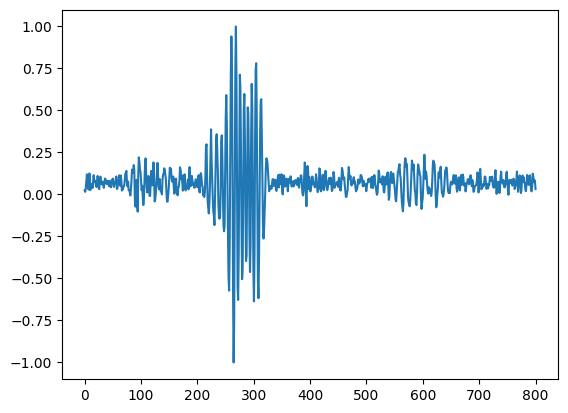

In [214]:
plt.plot(np.linspace(0, len(DUS_list[550]), 800),DUS_list[550])

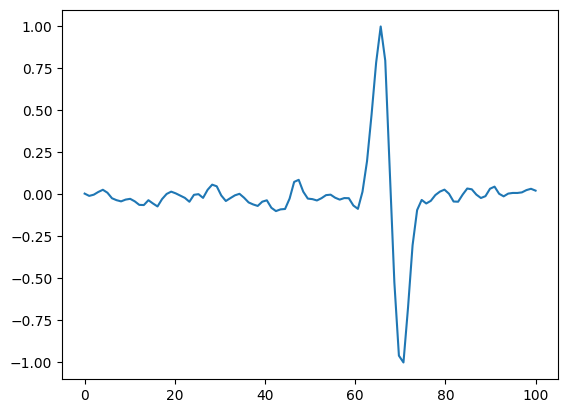

In [213]:
plt.plot(np.linspace(0, len(ECG_list[550]), 100),ECG_list[550])

In [22]:
loaded_data = np.load('./Leipzing_FHR_heartbeat.npz',allow_pickle=True)
DUS_list=loaded_data['DUS_list']
ECG_list=loaded_data['ECG_list']

In [23]:
len(ECG_list)

5103

In [5]:
import tensorflow as tf
DUS_array = np.array(DUS_list, dtype=np.float32)
ECG_array = np.array(ECG_list, dtype=np.float32)

dataset = tf.data.Dataset.from_tensor_slices((DUS_array, ECG_array))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

In [7]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 800), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400), dtype=tf.float32, name=None))>

In [13]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_all_1 = []
ECG_list_all_1 = []
DUS_list_all_2 = []
ECG_list_all_2 = []
DUS_list_all_3 = []
ECG_list_all_3 = []
DUS_list_all_4 = []
ECG_list_all_4 = []
DUS_list_all_5 = []
ECG_list_all_5 = []

DUS_list_all_train_1 = []
ECG_list_all_train_1 = []
DUS_list_all_train_2 = []
ECG_list_all_train_2 = []
DUS_list_all_train_3 = []
ECG_list_all_train_3 = []
DUS_list_all_train_4 = []
ECG_list_all_train_4 = []
DUS_list_all_train_5 = []
ECG_list_all_train_5 = []

FHR_list_all_1 = []
FHR_list_all_2 = []
FHR_list_all_3 = []
FHR_list_all_4 = []
FHR_list_all_5 = []
FHR_list_all_train_1 = []
FHR_list_all_train_2 = []
FHR_list_all_train_3 = []
FHR_list_all_train_4 = []
FHR_list_all_train_5 = []
    
tensor_all_list_all = []
label_list_all = []
beatset_list_all= []
FHR_list_all= []
DUS_list_all = []
ECG_list_all = []

t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)

            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])

            g_segments += 1
            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            windowed_rec=normalize_one(windowed_rec)

            for i in range(len(beatSet_time)):
                if (i == len(beatSet_time) - 2):
                    break
                
                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_2 = find_closest_index(t_Doppler, beatSet_time[i+2])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_2 = find_closest_index(t_ECG, beatSet_time[i+2])


                windowed_rec_beat = windowed_rec[round((i_d_1+i_d)/2):round((i_d_2+i_d_1)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,800)
                
                ECG_beat = ECG[round((i_t_1+i_t)/2):round((i_t_2+i_t_1)/2)]
                ECG_beat=normalize_one(ECG_beat)
                ECG_beat = modify_array(ECG_beat,100)


                if file_names[signal_num]=='AK101197V2':
                    DUS_list_all_1.append(windowed_rec_beat)
                    ECG_list_all_1.append(ECG_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_list_all_2.append(windowed_rec_beat)
                    ECG_list_all_2.append(ECG_beat)
                                
                if file_names[signal_num]=='MZ290383V2':
                    DUS_list_all_3.append(windowed_rec_beat)
                    ECG_list_all_3.append(ECG_beat)                    
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_list_all_4.append(windowed_rec_beat)
                    ECG_list_all_4.append(ECG_beat)                   
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_5.append(windowed_rec_beat)
                    ECG_list_all_5.append(ECG_beat)                   
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_list_all_train_5.append(windowed_rec_beat)
                    ECG_list_all_train_5.append(ECG_beat)                   
                
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_4.append(windowed_rec_beat)
                    ECG_list_all_train_4.append(ECG_beat)                
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_3.append(windowed_rec_beat)
                    ECG_list_all_train_3.append(ECG_beat)                  
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_2.append(windowed_rec_beat)
                    ECG_list_all_train_2.append(ECG_beat)                 
    
                if file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_1.append(windowed_rec_beat)
                    ECG_list_all_train_1.append(ECG_beat)
                    


DUS_list_all_1=np.array(DUS_list_all_1, dtype=object)
ECG_list_all_1=np.array(ECG_list_all_1, dtype=object)
DUS_list_all_2=np.array(DUS_list_all_2, dtype=object)
ECG_list_all_2=np.array(ECG_list_all_2, dtype=object)
DUS_list_all_3=np.array(DUS_list_all_3, dtype=object)
ECG_list_all_3=np.array(ECG_list_all_3, dtype=object)
DUS_list_all_4=np.array(DUS_list_all_4, dtype=object)
ECG_list_all_4=np.array(ECG_list_all_4, dtype=object)
DUS_list_all_5=np.array(DUS_list_all_5, dtype=object)
ECG_list_all_5=np.array(ECG_list_all_5, dtype=object)

DUS_list_all_train_1=np.array(DUS_list_all_train_1, dtype=object)
ECG_list_all_train_1=np.array(ECG_list_all_train_1, dtype=object)
DUS_list_all_train_2=np.array(DUS_list_all_train_2, dtype=object)
ECG_list_all_train_2=np.array(ECG_list_all_train_2, dtype=object)
DUS_list_all_train_3=np.array(DUS_list_all_train_3, dtype=object)
ECG_list_all_train_3=np.array(ECG_list_all_train_3, dtype=object)
DUS_list_all_train_4=np.array(DUS_list_all_train_4, dtype=object)
ECG_list_all_train_4=np.array(ECG_list_all_train_4, dtype=object)
DUS_list_all_train_5=np.array(DUS_list_all_train_5, dtype=object)
ECG_list_all_train_5=np.array(ECG_list_all_train_5, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_all_one_1.npz', DUS_list_all=DUS_list_all_1, ECG_list_all=ECG_list_all_1)
np.savez('./Leipzing_FHR_heartbeat_all_one_2.npz', DUS_list_all=DUS_list_all_2, ECG_list_all=ECG_list_all_2)
np.savez('./Leipzing_FHR_heartbeat_all_one_3.npz', DUS_list_all=DUS_list_all_3, ECG_list_all=ECG_list_all_3)
np.savez('./Leipzing_FHR_heartbeat_all_one_4.npz', DUS_list_all=DUS_list_all_4, ECG_list_all=ECG_list_all_4)
np.savez('./Leipzing_FHR_heartbeat_all_one_5.npz', DUS_list_all=DUS_list_all_5, ECG_list_all=ECG_list_all_5)

np.savez('./Leipzing_FHR_heartbeat_all_one_train_1.npz', DUS_list_all=DUS_list_all_train_1, ECG_list_all=ECG_list_all_train_1)
np.savez('./Leipzing_FHR_heartbeat_all_one_train_2.npz', DUS_list_all=DUS_list_all_train_2, ECG_list_all=ECG_list_all_train_2)
np.savez('./Leipzing_FHR_heartbeat_all_one_train_3.npz', DUS_list_all=DUS_list_all_train_3, ECG_list_all=ECG_list_all_train_3)
np.savez('./Leipzing_FHR_heartbeat_all_one_train_4.npz', DUS_list_all=DUS_list_all_train_4, ECG_list_all=ECG_list_all_train_4)
np.savez('./Leipzing_FHR_heartbeat_all_one_train_5.npz', DUS_list_all=DUS_list_all_train_5, ECG_list_all=ECG_list_all_train_5)

0
1
2
3
4


## DUS extraction

In [10]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_noise_list_1 = []
ECG_list_1 = []
DUS_noise_list_2 = []
ECG_list_2 = []
DUS_noise_list_3 = []
ECG_list_3 = []
DUS_noise_list_4 = []
ECG_list_4 = []
DUS_noise_list_5 = []
ECG_list_5 = []

DUS_noise_list_train = []
ECG_list_train = []
    
tensor_all_list = []
label_list = []
beatset_list= []
FHR_list= []
DUS_noise_list = []
ECG_list = []
t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)


            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            windowed_rec=normalize_one(windowed_rec)

            for i in range(len(beatSet_time)):
                if (i == len(beatSet_time) - 2):
                    break
                
                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_2 = find_closest_index(t_Doppler, beatSet_time[i+2])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_2 = find_closest_index(t_ECG, beatSet_time[i+2])


                windowed_rec_beat = windowed_rec_resampled[round((i_d_1+i_d)/2):round((i_d_2+i_d_1)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,800)
                

                if file_names[signal_num]=='AK101197V2':
                    DUS_noise_list_1.append(windowed_rec_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_noise_list_2.append(windowed_rec_beat)
                               
                if file_names[signal_num]=='MZ290383V2':
                    DUS_noise_list_3.append(windowed_rec_beat)
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_noise_list_4.append(windowed_rec_beat)
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_noise_list_5.append(windowed_rec_beat)

                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_noise_list_train.append(windowed_rec_beat)

DUS_noise_list_1=np.array(DUS_noise_list_1, dtype=object)
DUS_noise_list_2=np.array(DUS_noise_list_2, dtype=object)
DUS_noise_list_3=np.array(DUS_noise_list_3, dtype=object)
DUS_noise_list_4=np.array(DUS_noise_list_4, dtype=object)
DUS_noise_list_5=np.array(DUS_noise_list_5, dtype=object)

DUS_noise_list_train=np.array(DUS_noise_list_train, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_noise_1.npz', DUS_list=DUS_noise_list_1)
np.savez('./Leipzing_FHR_heartbeat_noise_2.npz', DUS_list=DUS_noise_list_2)
np.savez('./Leipzing_FHR_heartbeat_noise_3.npz', DUS_list=DUS_noise_list_3)
np.savez('./Leipzing_FHR_heartbeat_noise_4.npz', DUS_list=DUS_noise_list_4)
np.savez('./Leipzing_FHR_heartbeat_noise_5.npz', DUS_list=DUS_noise_list_5)

np.savez('./Leipzing_FHR_heartbeat_noise_train.npz', DUS_list=DUS_noise_list_train)

0
1
2
3
4


In [16]:

fECG['fECG']

array([[-0.07839918, -0.48223523, -0.71704553, ...,  0.28879662,
        -0.29566976, -0.88929372]])

In [46]:
len(DUS_noise_list_1)+len(DUS_noise_list_2)+len(DUS_noise_list_3)+len(DUS_noise_list_4)+len(DUS_noise_list_5)


5103

# 2-beat extraction

In [14]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_all_1 = []
ECG_list_all_1 = []
DUS_list_all_2 = []
ECG_list_all_2 = []
DUS_list_all_3 = []
ECG_list_all_3 = []
DUS_list_all_4 = []
ECG_list_all_4 = []
DUS_list_all_5 = []
ECG_list_all_5 = []

DUS_list_all_train_1 = []
ECG_list_all_train_1 = []
DUS_list_all_train_2 = []
ECG_list_all_train_2 = []
DUS_list_all_train_3 = []
ECG_list_all_train_3 = []
DUS_list_all_train_4 = []
ECG_list_all_train_4 = []
DUS_list_all_train_5 = []
ECG_list_all_train_5 = []

FHR_list_all_1 = []
FHR_list_all_2 = []
FHR_list_all_3 = []
FHR_list_all_4 = []
FHR_list_all_5 = []
FHR_list_all_train_1 = []
FHR_list_all_train_2 = []
FHR_list_all_train_3 = []
FHR_list_all_train_4 = []
FHR_list_all_train_5 = []
    
tensor_all_list_all = []
label_list_all = []
beatset_list_all= []
FHR_list_all= []
DUS_list_all = []
ECG_list_all = []
t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)

            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])

            g_segments += 1
            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            windowed_rec=normalize_one(windowed_rec)

            for i in range(0, len(beatSet_time), 2):
                if (i >= len(beatSet_time) - 3):
                    break

                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_2 = find_closest_index(t_Doppler, beatSet_time[i+2])
                i_d_3 = find_closest_index(t_Doppler, beatSet_time[i+3])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_2 = find_closest_index(t_ECG, beatSet_time[i+2])
                i_t_3 = find_closest_index(t_ECG, beatSet_time[i+3])


                windowed_rec_beat = windowed_rec[round((i_d_1+i_d)/2):round((i_d_2+i_d_3)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,1600)
                
                ECG_beat = ECG[round((i_t_1+i_t)/2):round((i_t_2+i_t_3)/2)]
                ECG_beat=normalize_one(ECG_beat)
                ECG_beat = modify_array(ECG_beat,200)

                #label_windowed_rec[:]=[FHR,signal_num]

                #f=create_scalogram(windowed_rec,target_fs_Doppler,time_bins, freq_bins)
                #f=normalize(f)
                #tensor_rec[0,:,:]=f.T
                if file_names[signal_num]=='AK101197V2':
                    DUS_list_all_1.append(windowed_rec_beat)
                    ECG_list_all_1.append(ECG_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_list_all_2.append(windowed_rec_beat)
                    ECG_list_all_2.append(ECG_beat)
                                
                if file_names[signal_num]=='MZ290383V2':
                    DUS_list_all_3.append(windowed_rec_beat)
                    ECG_list_all_3.append(ECG_beat)                    
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_list_all_4.append(windowed_rec_beat)
                    ECG_list_all_4.append(ECG_beat)                   
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_5.append(windowed_rec_beat)
                    ECG_list_all_5.append(ECG_beat)                   
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_list_all_train_5.append(windowed_rec_beat)
                    ECG_list_all_train_5.append(ECG_beat)                   
                
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_4.append(windowed_rec_beat)
                    ECG_list_all_train_4.append(ECG_beat)                
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_3.append(windowed_rec_beat)
                    ECG_list_all_train_3.append(ECG_beat)                  
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_2.append(windowed_rec_beat)
                    ECG_list_all_train_2.append(ECG_beat)                 
    
                if file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_1.append(windowed_rec_beat)
                    ECG_list_all_train_1.append(ECG_beat)
                    

DUS_list_all_1=np.array(DUS_list_all_1, dtype=object)
ECG_list_all_1=np.array(ECG_list_all_1, dtype=object)
DUS_list_all_2=np.array(DUS_list_all_2, dtype=object)
ECG_list_all_2=np.array(ECG_list_all_2, dtype=object)
DUS_list_all_3=np.array(DUS_list_all_3, dtype=object)
ECG_list_all_3=np.array(ECG_list_all_3, dtype=object)
DUS_list_all_4=np.array(DUS_list_all_4, dtype=object)
ECG_list_all_4=np.array(ECG_list_all_4, dtype=object)
DUS_list_all_5=np.array(DUS_list_all_5, dtype=object)
ECG_list_all_5=np.array(ECG_list_all_5, dtype=object)

DUS_list_all_train_1=np.array(DUS_list_all_train_1, dtype=object)
ECG_list_all_train_1=np.array(ECG_list_all_train_1, dtype=object)
DUS_list_all_train_2=np.array(DUS_list_all_train_2, dtype=object)
ECG_list_all_train_2=np.array(ECG_list_all_train_2, dtype=object)
DUS_list_all_train_3=np.array(DUS_list_all_train_3, dtype=object)
ECG_list_all_train_3=np.array(ECG_list_all_train_3, dtype=object)
DUS_list_all_train_4=np.array(DUS_list_all_train_4, dtype=object)
ECG_list_all_train_4=np.array(ECG_list_all_train_4, dtype=object)
DUS_list_all_train_5=np.array(DUS_list_all_train_5, dtype=object)
ECG_list_all_train_5=np.array(ECG_list_all_train_5, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_all_two_1.npz', DUS_list_all=DUS_list_all_1, ECG_list_all=ECG_list_all_1)
np.savez('./Leipzing_FHR_heartbeat_all_two_2.npz', DUS_list_all=DUS_list_all_2, ECG_list_all=ECG_list_all_2)
np.savez('./Leipzing_FHR_heartbeat_all_two_3.npz', DUS_list_all=DUS_list_all_3, ECG_list_all=ECG_list_all_3)
np.savez('./Leipzing_FHR_heartbeat_all_two_4.npz', DUS_list_all=DUS_list_all_4, ECG_list_all=ECG_list_all_4)
np.savez('./Leipzing_FHR_heartbeat_all_two_5.npz', DUS_list_all=DUS_list_all_5, ECG_list_all=ECG_list_all_5)

np.savez('./Leipzing_FHR_heartbeat_all_two_train_1.npz', DUS_list_all=DUS_list_all_train_1, ECG_list_all=ECG_list_all_train_1)
np.savez('./Leipzing_FHR_heartbeat_all_two_train_2.npz', DUS_list_all=DUS_list_all_train_2, ECG_list_all=ECG_list_all_train_2)
np.savez('./Leipzing_FHR_heartbeat_all_two_train_3.npz', DUS_list_all=DUS_list_all_train_3, ECG_list_all=ECG_list_all_train_3)
np.savez('./Leipzing_FHR_heartbeat_all_two_train_4.npz', DUS_list_all=DUS_list_all_train_4, ECG_list_all=ECG_list_all_train_4)
np.savez('./Leipzing_FHR_heartbeat_all_two_train_5.npz', DUS_list_all=DUS_list_all_train_5, ECG_list_all=ECG_list_all_train_5)

0
1
2
3
4


## 3-beats

In [ ]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_all_1 = []
ECG_list_all_1 = []
DUS_list_all_2 = []
ECG_list_all_2 = []
DUS_list_all_3 = []
ECG_list_all_3 = []
DUS_list_all_4 = []
ECG_list_all_4 = []
DUS_list_all_5 = []
ECG_list_all_5 = []

DUS_list_all_train_1 = []
ECG_list_all_train_1 = []
DUS_list_all_train_2 = []
ECG_list_all_train_2 = []
DUS_list_all_train_3 = []
ECG_list_all_train_3 = []
DUS_list_all_train_4 = []
ECG_list_all_train_4 = []
DUS_list_all_train_5 = []
ECG_list_all_train_5 = []

FHR_list_all_1 = []
FHR_list_all_2 = []
FHR_list_all_3 = []
FHR_list_all_4 = []
FHR_list_all_5 = []
FHR_list_all_train_1 = []
FHR_list_all_train_2 = []
FHR_list_all_train_3 = []
FHR_list_all_train_4 = []
FHR_list_all_train_5 = []
    
tensor_all_list_all = []
label_list_all = []
beatset_list_all= []
FHR_list_all= []
DUS_list_all = []
ECG_list_all = []
t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)

            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])

            g_segments += 1
            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            windowed_rec=normalize_one(windowed_rec)

            for i in range(0, len(beatSet_time), 3):
                if (i >= len(beatSet_time) - 4):
                    break
                
                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_3 = find_closest_index(t_Doppler, beatSet_time[i+3])
                i_d_4 = find_closest_index(t_Doppler, beatSet_time[i+4])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_3 = find_closest_index(t_ECG, beatSet_time[i+3])
                i_t_4 = find_closest_index(t_ECG, beatSet_time[i+4])


                windowed_rec_beat = windowed_rec[round((i_d_1+i_d)/2):round((i_d_3+i_d_4)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,2400)
                
                ECG_beat = ECG[round((i_t_1+i_t)/2):round((i_t_3+i_t_4)/2)]
                ECG_beat=normalize_one(ECG_beat)
                ECG_beat = modify_array(ECG_beat,300)

                #label_windowed_rec[:]=[FHR,signal_num]

                #f=create_scalogram(windowed_rec,target_fs_Doppler,time_bins, freq_bins)
                #f=normalize(f)
                #tensor_rec[0,:,:]=f.T
                if file_names[signal_num]=='AK101197V2':
                    DUS_list_all_1.append(windowed_rec_beat)
                    ECG_list_all_1.append(ECG_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_list_all_2.append(windowed_rec_beat)
                    ECG_list_all_2.append(ECG_beat)
                                
                if file_names[signal_num]=='MZ290383V2':
                    DUS_list_all_3.append(windowed_rec_beat)
                    ECG_list_all_3.append(ECG_beat)                    
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_list_all_4.append(windowed_rec_beat)
                    ECG_list_all_4.append(ECG_beat)                   
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_5.append(windowed_rec_beat)
                    ECG_list_all_5.append(ECG_beat)                   
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_list_all_train_5.append(windowed_rec_beat)
                    ECG_list_all_train_5.append(ECG_beat)                   
                
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_4.append(windowed_rec_beat)
                    ECG_list_all_train_4.append(ECG_beat)                
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_3.append(windowed_rec_beat)
                    ECG_list_all_train_3.append(ECG_beat)                  
    
                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_2.append(windowed_rec_beat)
                    ECG_list_all_train_2.append(ECG_beat)                 
    
                if file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2' or file_names[signal_num]=='SB280780_1V2':
                    DUS_list_all_train_1.append(windowed_rec_beat)
                    ECG_list_all_train_1.append(ECG_beat)
                    
DUS_list_all_1=np.array(DUS_list_all_1, dtype=object)
ECG_list_all_1=np.array(ECG_list_all_1, dtype=object)
DUS_list_all_2=np.array(DUS_list_all_2, dtype=object)
ECG_list_all_2=np.array(ECG_list_all_2, dtype=object)
DUS_list_all_3=np.array(DUS_list_all_3, dtype=object)
ECG_list_all_3=np.array(ECG_list_all_3, dtype=object)
DUS_list_all_4=np.array(DUS_list_all_4, dtype=object)
ECG_list_all_4=np.array(ECG_list_all_4, dtype=object)
DUS_list_all_5=np.array(DUS_list_all_5, dtype=object)
ECG_list_all_5=np.array(ECG_list_all_5, dtype=object)

DUS_list_all_train_1=np.array(DUS_list_all_train_1, dtype=object)
ECG_list_all_train_1=np.array(ECG_list_all_train_1, dtype=object)
DUS_list_all_train_2=np.array(DUS_list_all_train_2, dtype=object)
ECG_list_all_train_2=np.array(ECG_list_all_train_2, dtype=object)
DUS_list_all_train_3=np.array(DUS_list_all_train_3, dtype=object)
ECG_list_all_train_3=np.array(ECG_list_all_train_3, dtype=object)
DUS_list_all_train_4=np.array(DUS_list_all_train_4, dtype=object)
ECG_list_all_train_4=np.array(ECG_list_all_train_4, dtype=object)
DUS_list_all_train_5=np.array(DUS_list_all_train_5, dtype=object)
ECG_list_all_train_5=np.array(ECG_list_all_train_5, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_all_three_1.npz', DUS_list_all=DUS_list_all_1, ECG_list_all=ECG_list_all_1)
np.savez('./Leipzing_FHR_heartbeat_all_three_2.npz', DUS_list_all=DUS_list_all_2, ECG_list_all=ECG_list_all_2)
np.savez('./Leipzing_FHR_heartbeat_all_three_3.npz', DUS_list_all=DUS_list_all_3, ECG_list_all=ECG_list_all_3)
np.savez('./Leipzing_FHR_heartbeat_all_three_4.npz', DUS_list_all=DUS_list_all_4, ECG_list_all=ECG_list_all_4)
np.savez('./Leipzing_FHR_heartbeat_all_three_5.npz', DUS_list_all=DUS_list_all_5, ECG_list_all=ECG_list_all_5)

np.savez('./Leipzing_FHR_heartbeat_all_three_train_1.npz', DUS_list_all=DUS_list_all_train_1, ECG_list_all=ECG_list_all_train_1)
np.savez('./Leipzing_FHR_heartbeat_all_three_train_2.npz', DUS_list_all=DUS_list_all_train_2, ECG_list_all=ECG_list_all_train_2)
np.savez('./Leipzing_FHR_heartbeat_all_three_train_3.npz', DUS_list_all=DUS_list_all_train_3, ECG_list_all=ECG_list_all_train_3)
np.savez('./Leipzing_FHR_heartbeat_all_three_train_4.npz', DUS_list_all=DUS_list_all_train_4, ECG_list_all=ECG_list_all_train_4)
np.savez('./Leipzing_FHR_heartbeat_all_three_train_5.npz', DUS_list_all=DUS_list_all_train_5, ECG_list_all=ECG_list_all_train_5)

In [24]:
fs_ECG=1000
target_fs_Doppler=2000
target_fs_ECG=250

freq_bins=40
time_bins=250
win_len=3.75

DUS_list_1 = []
ECG_list_1 = []
DUS_list_2 = []
ECG_list_2 = []
DUS_list_3 = []
ECG_list_3 = []
DUS_list_4 = []
ECG_list_4 = []
DUS_list_5 = []
ECG_list_5 = []

DUS_list_train = []
ECG_list_train = []
    
tensor_all_list = []
label_list = []
beatset_list= []
FHR_list= []
DUS_list = []
ECG_list = []
t_Doppler = np.linspace(0, 3.75, 7500)
t_ECG = np.linspace(0, 3.75, 1000)
g_segments = 0

for signal_num in range(len(signals)):
    print(signal_num)
    
    if file_names[signal_num]=='MZ290383V2':
        fs_Doppler=10000
    else:
        fs_Doppler=20000
    
    SQI_len=min(len(SQI_1[signal_num]),len(SQI_2[signal_num]))
    
    #try:
    
    for page in range(SQI_len):
        tensor_rec=np.zeros((1,time_bins,freq_bins))
        #label_windowed_rec=np.zeros((1,2))
        
        if SQI_1[signal_num][page]==1 and SQI_2[signal_num][page]==1: #Good segments

            start_time=page*win_len
            end_time=(page+1)*win_len

            start_Index_ECG = start_time*fs_ECG
            end_Index_ECG = end_time*fs_ECG

            start_Index_Doppler = start_time*fs_Doppler
            end_Index_Doppler = end_time*fs_Doppler

            ECG_page_anno1 = ECG_1[signal_num][(ECG_1[signal_num] >= start_Index_ECG) & (ECG_1[signal_num] <= end_Index_ECG)]
            ECG_page_anno2 = ECG_2[signal_num][(ECG_2[signal_num] >= start_Index_ECG) & (ECG_2[signal_num] <= end_Index_ECG)]


            beatSet = groupingBeats_leipzig(ECG_page_anno1, ECG_page_anno2,fs_ECG)
            beatSet_time=np.array(beatSet)/fs_ECG-start_time


            diffFHR = []
            for bIdx in range(1, len(beatSet)):
                if beatSet[bIdx] - beatSet[bIdx - 1] <= fs_ECG * (2 / 3): #Greater than 90 bpm
                    diffFHR.append(beatSet[bIdx] - beatSet[bIdx - 1])
                    
            #FHR_all=60 / (np.array(diffFHR) / fs_ECG)
            #FHR = 60 / np.median(np.array(diffFHR) / fs_ECG)

            ECG_SQI_CH_1 = []
            ECG_SQI_CH_2 = []
            
            for i in range(7):
                ECG_SQI_CH_1.append(ECG_SQI_1[signal_num][i][page])
                ECG_SQI_CH_2.append(ECG_SQI_2[signal_num][i][page])
                
            zero_sqi_channels = np.where((np.array(ECG_SQI_CH_1) == 0) & (np.array(ECG_SQI_CH_2) == 0))[0]

            if zero_sqi_channels.size > 0:
                sqi = int(random.choice(zero_sqi_channels))
                
            sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
            if all(value > 5 for value in sqi_sum) or ECG_SQI_CH_1 == 4 or ECG_SQI_CH_2 == 4:
                continue
            
            else:
                sqi_sum = [x + y for x, y in zip(ECG_SQI_CH_1, ECG_SQI_CH_2)]
                min_sqi_sum = np.min(sqi_sum)
                candidates = np.where(sqi_sum == min_sqi_sum)[0]
                if len(candidates) > 1:
                    cd_inx = candidates.tolist()[0]
                    min_sqi_1 = np.min(ECG_SQI_CH_1[cd_inx])
                    min_sqi_2 = np.min(ECG_SQI_CH_2[cd_inx])
            
                    final_candidates = [c for c in candidates if ECG_SQI_CH_1[c] == min_sqi_1 or ECG_SQI_CH_2[c] == min_sqi_2]
            
                    if len(final_candidates) > 1:
                        sqi = int(random.choice(final_candidates))
                    else:
                        sqi = int(final_candidates[0])
                else:
                    sqi = int(candidates[0])

            g_segments += 1
            ECG=ECGs_2[signal_num][sqi][int(start_Index_ECG):int(end_Index_ECG)]
            ECG=signal_resample(ECG, fs_ECG, target_fs_ECG)
            ECG=ECG_filtering(ECG, target_fs_ECG)
            ECG=normalize_one(ECG)

            windowed_rec_original=signals[signal_num][int(start_Index_Doppler):int(end_Index_Doppler)]

            windowed_rec_resampled=signal_resample(windowed_rec_original, fs_Doppler, target_fs_Doppler)
            windowed_rec=DUS_filtering(windowed_rec_resampled)
            #windowed_rec=normalize_one(windowed_rec)

            for i in range(0, len(beatSet_time), 3):
                if (i >= len(beatSet_time) - 5):
                    break
                
                i_d = find_closest_index(t_Doppler, beatSet_time[i])
                i_d_1 = find_closest_index(t_Doppler, beatSet_time[i+1])
                i_d_4 = find_closest_index(t_Doppler, beatSet_time[i+4])
                i_d_5 = find_closest_index(t_Doppler, beatSet_time[i+5])
                
                i_t = find_closest_index(t_ECG, beatSet_time[i])
                i_t_1 = find_closest_index(t_ECG, beatSet_time[i+1])
                i_t_4 = find_closest_index(t_ECG, beatSet_time[i+4])
                i_t_5 = find_closest_index(t_ECG, beatSet_time[i+5])


                windowed_rec_beat = windowed_rec[round((i_d_1+i_d)/2):round((i_d_5+i_d_4)/2)]
                windowed_rec_beat = normalize_one(windowed_rec_beat)
                windowed_rec_beat = modify_array(windowed_rec_beat,3200)
                
                ECG_beat = ECG[round((i_t_1+i_t)/2):round((i_t_5+i_t_4)/2)]
                ECG_beat=normalize_one(ECG_beat)
                ECG_beat = modify_array(ECG_beat,400)

                #label_windowed_rec[:]=[FHR,signal_num]

                #f=create_scalogram(windowed_rec,target_fs_Doppler,time_bins, freq_bins)
                #f=normalize(f)
                #tensor_rec[0,:,:]=f.T
                if file_names[signal_num]=='AK101197V2':
                    DUS_list_1.append(windowed_rec_beat)
                    ECG_list_1.append(ECG_beat)
                               
                if file_names[signal_num]=='CB300482IIIV2':
                    DUS_list_2.append(windowed_rec_beat)
                    ECG_list_2.append(ECG_beat)
                               
                if file_names[signal_num]=='MZ290383V2':
                    DUS_list_3.append(windowed_rec_beat)
                    ECG_list_3.append(ECG_beat)
                               
                if file_names[signal_num]=='RM040883IIV2':
                    DUS_list_4.append(windowed_rec_beat)
                    ECG_list_4.append(ECG_beat)
                                
                if file_names[signal_num]=='SB280780_1V2':
                    DUS_list_5.append(windowed_rec_beat)
                    ECG_list_5.append(ECG_beat)

                if file_names[signal_num]=='AK101197V2' or file_names[signal_num]=='CB300482IIIV2' or file_names[signal_num]=='MZ290383V2' or file_names[signal_num]=='RM040883IIV2':
                    DUS_list_train.append(windowed_rec_beat)
                    ECG_list_train.append(ECG_beat)
                    
                #tensor_all_list.append(tensor_rec)
                #label_list.append(label_windowed_rec)
                #FHR_list.append(FHR_all)
                #DUS_list.append(windowed_rec_beat)
                #ECG_list.append(ECG_beat)
                
    #except Exception as e:
        #print(f"Error in {file_names[signal_num]}: {e}")

#tensor_all = np.concatenate(tensor_all_list, axis=0)
#label_all = np.concatenate(label_list, axis=0)
#beatset_list=np.array(beatset_list, dtype=object)
#FHR_list=np.array(FHR_list, dtype=object)
print(g_segments)
DUS_list_1=np.array(DUS_list_1, dtype=object)
ECG_list_1=np.array(ECG_list_1, dtype=object)
DUS_list_2=np.array(DUS_list_2, dtype=object)
ECG_list_2=np.array(ECG_list_2, dtype=object)
DUS_list_3=np.array(DUS_list_3, dtype=object)
ECG_list_3=np.array(ECG_list_3, dtype=object)
DUS_list_4=np.array(DUS_list_4, dtype=object)
ECG_list_4=np.array(ECG_list_4, dtype=object)
DUS_list_5=np.array(DUS_list_5, dtype=object)
ECG_list_5=np.array(ECG_list_5, dtype=object)

DUS_list_train=np.array(DUS_list_train, dtype=object)
ECG_list_train=np.array(ECG_list_train, dtype=object)

np.savez('./Leipzing_FHR_heartbeat_four_beats_1.npz', DUS_list=DUS_list_1, ECG_list=ECG_list_1)
np.savez('./Leipzing_FHR_heartbeat_four_beats_2.npz', DUS_list=DUS_list_2, ECG_list=ECG_list_2)
np.savez('./Leipzing_FHR_heartbeat_four_beats_3.npz', DUS_list=DUS_list_3, ECG_list=ECG_list_3)
np.savez('./Leipzing_FHR_heartbeat_four_beats_4.npz', DUS_list=DUS_list_4, ECG_list=ECG_list_4)
np.savez('./Leipzing_FHR_heartbeat_four_beats_5.npz', DUS_list=DUS_list_5, ECG_list=ECG_list_5)

np.savez('./Leipzing_FHR_heartbeat_four_beats_train.npz', DUS_list=DUS_list_train, ECG_list=ECG_list_train)

0
1
2
3
4
564
